In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

from sqlalchemy import create_engine, inspect, text
import os

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
engine = create_engine(os.environ["REDSHIFT_READ_URI"], echo=False)

def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  df = pd.DataFrame(dados, columns= consulta.keys())
  return df

In [3]:
producao = ''' 
select 
ap.created_at,
ap.deal_id,
down_payment,
installment,
operation_value,
proposal_type,
installment_count,
ap.days_of_delay,
coalesce(d.de,0) || ' a ' || coalesce(d.ate,0) as faixa_atraso,
medium
from quiteja_dados.analitico_producao_37 ap
join quiteja_dados.dimensoes d on ap.days_of_delay between coalesce(d.de,0) and coalesce(d.ate,999999) and d.creditor_id = 37 and d.tipo_cluster = 'Atraso'
where ap.created_at > '2023-10-01' '''

In [4]:
consolidacao = '''
select 
deal_id,
contact_id,
debt_value,
principal_value,
days_of_delay,
coalesce(dm.de,0) || ' a ' || coalesce(dm.ate,0) as faixa_atraso,
contact_type,
contact_status  
from consolidacao_carteira.deal_37 d 
join consolidacao_carteira.customer_37 c on d.customer_id = c.customer_id and c.is_approachable is true and c.is_blacklist is False 
join consolidacao_carteira.contact_37 c2 on d.customer_id = c2.customer_id AND c2.is_blacklist is False AND c2.is_quarentine is false AND c2.is_contact_notifiable is true and has_hot is true
join quiteja_dados.dimensoes dm on d.days_of_delay between coalesce(dm.de,0) and coalesce(dm.ate) and dm.creditor_id = 37 and dm.tipo_cluster =  'Atraso'
'''


consolidacao_deal = '''
select 
distinct deal_id,
contact_id,
debt_value,
principal_value,
days_of_delay,
coalesce(dm.de,0) || ' a ' || coalesce(dm.ate,0) as faixa_atraso,
contact_type,
contact_status  
from consolidacao_carteira.deal_37 d 
join consolidacao_carteira.customer_37 c on d.customer_id = c.customer_id and c.is_approachable is true and c.is_blacklist is False 
join consolidacao_carteira.contact_37 c2 on d.customer_id = c2.customer_id AND c2.is_blacklist is False AND c2.is_quarentine is false AND c2.is_contact_notifiable is true and has_hot is true
join quiteja_dados.dimensoes dm on d.days_of_delay between coalesce(dm.de,0) and coalesce(dm.ate) and dm.creditor_id = 37 and dm.tipo_cluster =  'Atraso'
'''

In [5]:
estimulos = '''
select 
sent_at,
contact_id,
contact_type,
contact_final_score,
days_of_delay,
coalesce(d.de,0) || ' a ' || coalesce(d.ate,999999) faixa_atraso,
debt_value,
principal_value,
incash_value,
incash_potential,
incash_discount,
max_installments,
strategy_public,
approach_type
from quiteja_dados.analitico_estimulos_37 ae
join quiteja_dados.dimensoes d on ae.days_of_delay between coalesce(d.de,0) and coalesce(d.ate,999999) and d.creditor_id = 37 and d.tipo_cluster = 'Atraso'
where sent_at  > '2024-01-01' '''

In [6]:
consolidacao = sql_df(consolidacao)

In [7]:
estimulos = sql_df(estimulos)

MemoryError: Unable to allocate 95.5 MiB for an array with shape (12517378,) and data type uint64

In [ ]:
producao = sql_df(producao)

# Produção 

In [ ]:
round(producao.describe(),2)

,deal_id,down_payment,installment,operation_value,installment_count,days_of_delay
count,8.473000e+03,8473.00,7462.00,8473.00,8473.00,8473.00
mean,2.090010e+08,270.40,1868.38,5086.35,7.21,441.22
std,1.923306e+07,415.96,2247.28,8446.12,5.17,626.31
min,1.951411e+08,11.97,50.91,20.21,0.00,32.00
25%,1.961126e+08,96.31,521.32,899.93,3.00,77.00
50%,1.970105e+08,169.77,1173.55,2332.74,6.00,235.00
75%,2.187737e+08,295.59,2342.75,5693.61,11.00,502.00
max,2.756777e+08,11155.28,30756.98,179636.90,23.00,5221.00


<Axes: xlabel='operation_value', ylabel='faixa_atraso'>

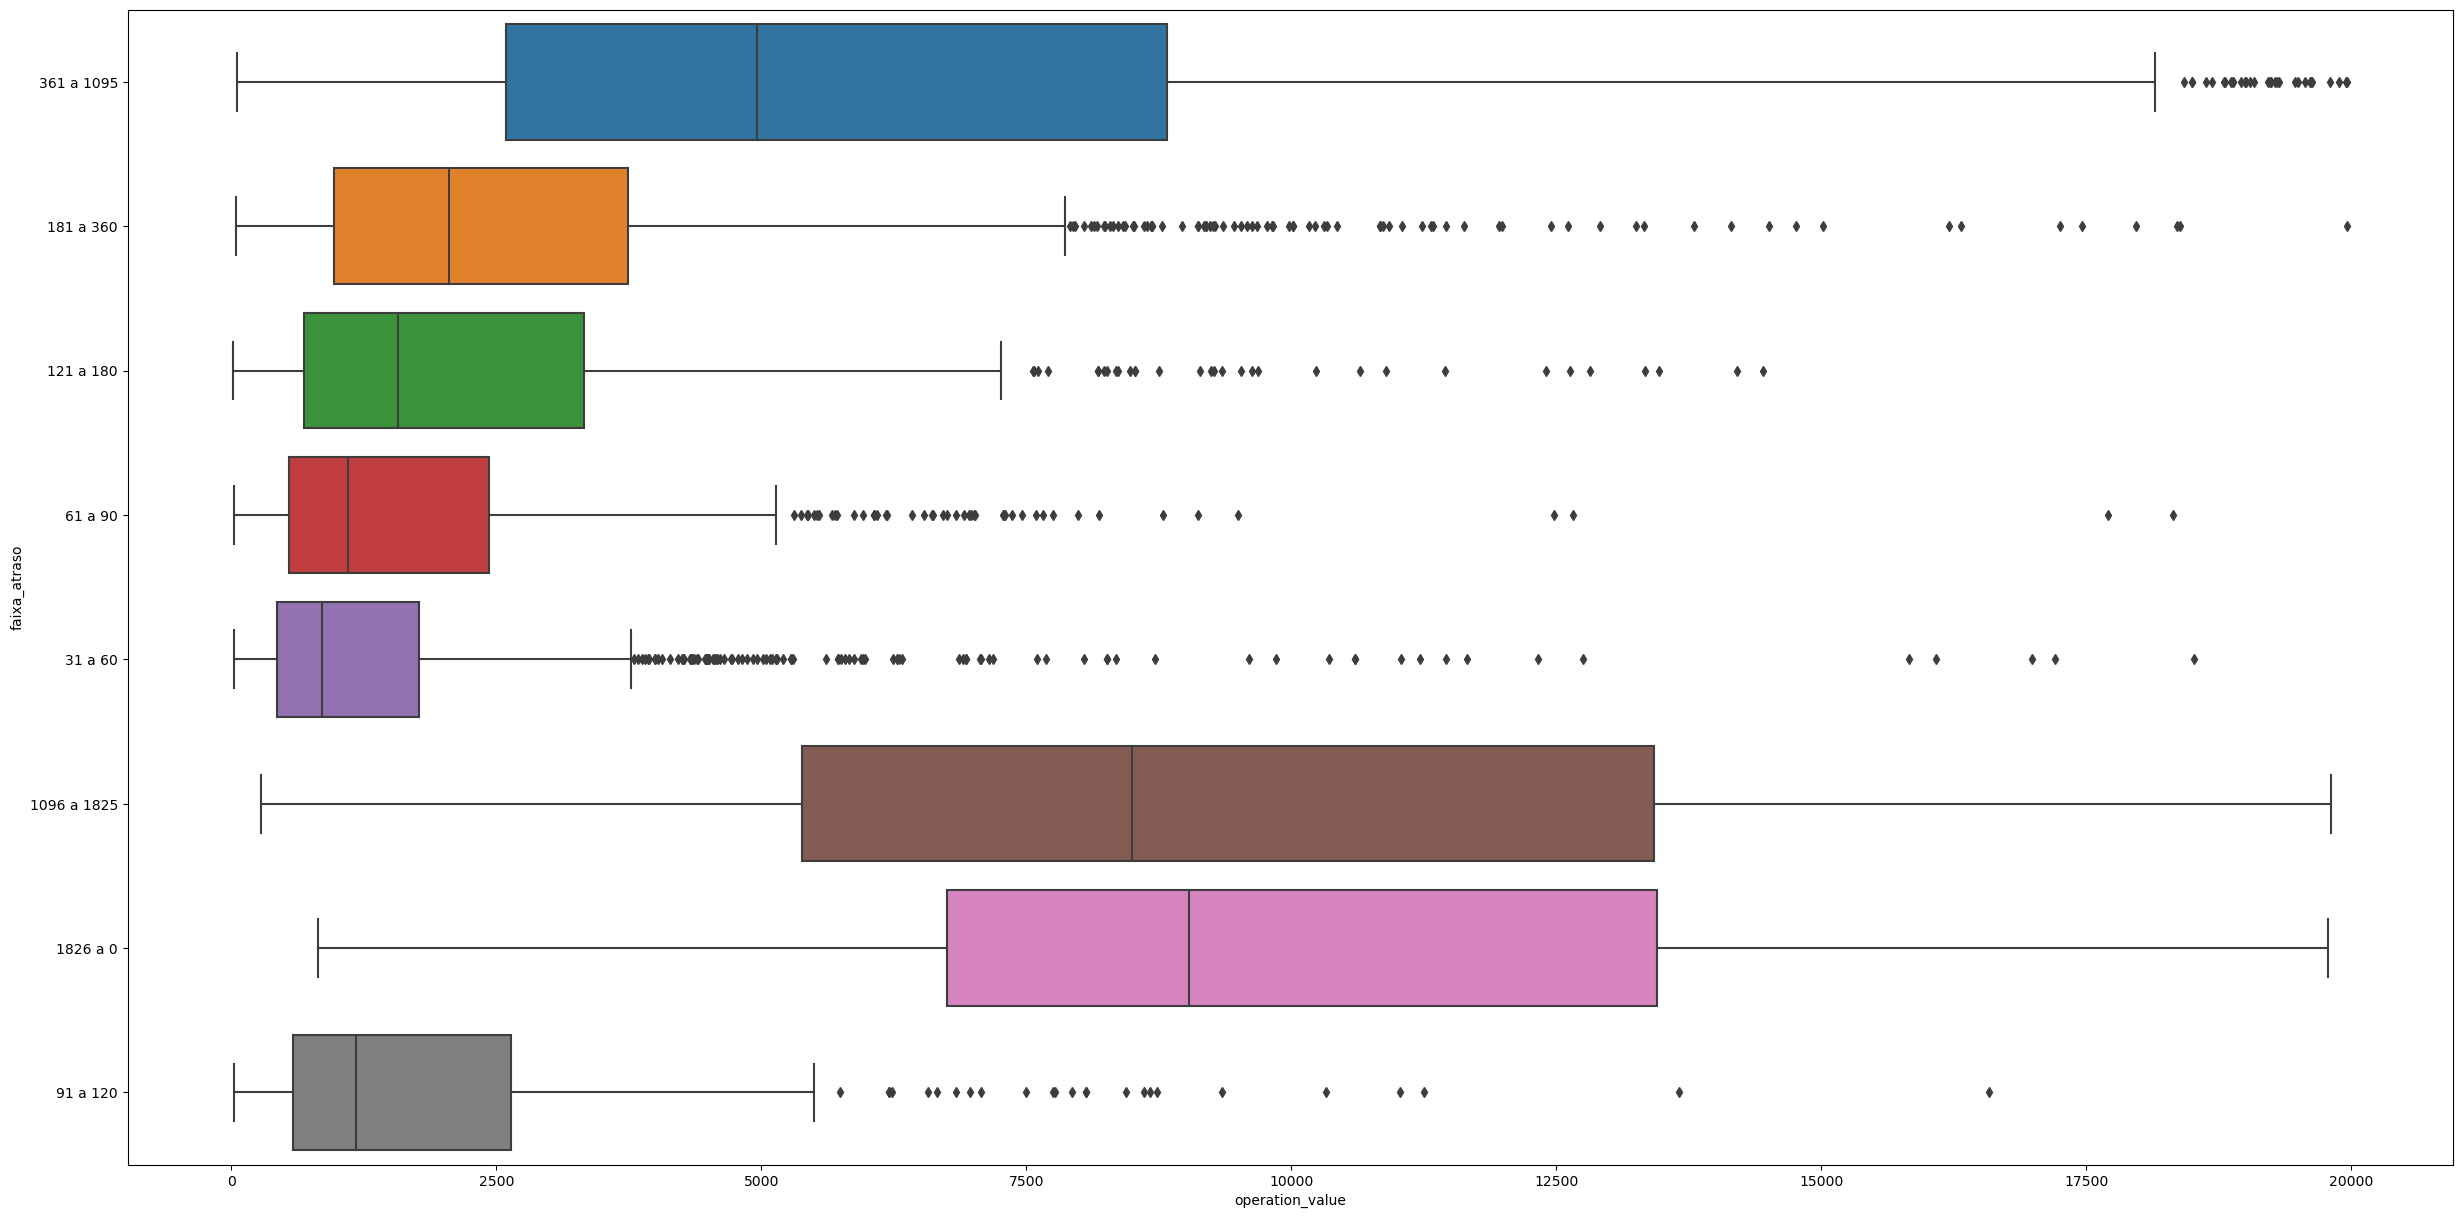

In [ ]:
plt.figure(figsize=(30,15))
sns.boxplot(x = producao[producao['operation_value'] < 20000]['operation_value'], y=producao['faixa_atraso'])

<Axes: xlabel='operation_value', ylabel='Count'>

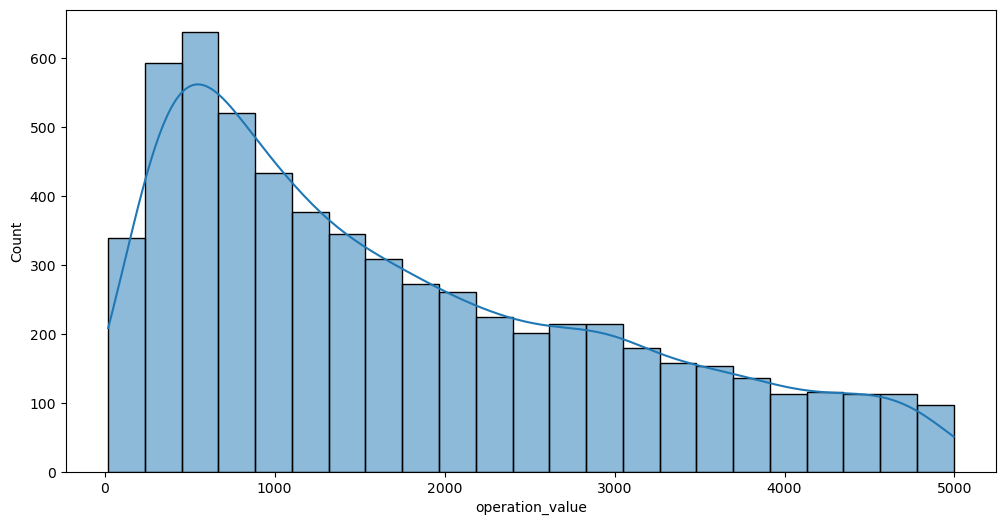

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(producao[producao['operation_value'] < 5000]['operation_value'], kde = True)

In [ ]:
round(pd.crosstab(producao['proposal_type'], producao['faixa_atraso'], normalize=True) * 100,2)

faixa_atraso,1096 a 1825,121 a 180,181 a 360,1826 a 0,31 a 60,361 a 1095,61 a 90,91 a 120
proposal_type,,,,,,,,
A prazo,5.07,7.27,18.77,3.42,15.98,22.88,9.42,5.25
A vista,0.59,0.57,3.74,0.71,2.41,2.61,0.85,0.46


In [ ]:
round(pd.crosstab(producao['medium'], producao['faixa_atraso'], normalize=True) * 100,2)

faixa_atraso,1096 a 1825,121 a 180,181 a 360,1826 a 0,31 a 60,361 a 1095,61 a 90,91 a 120
medium,,,,,,,,
E-MAIL,1.19,1.31,3.17,0.66,2.83,5.25,1.40,0.80
ORGANICO,0.34,0.39,1.19,0.32,0.57,1.85,0.46,0.18
PUSH,0.35,0.45,0.98,0.30,0.78,1.55,0.38,0.33
SMS,3.65,5.20,15.84,2.58,13.30,15.22,7.39,3.95
URA,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
WHATSAPP,0.13,0.48,1.32,0.27,0.91,1.61,0.64,0.45


É possível observar que a faixa de atraso de 181-360 e 361-720 possuem um bom potêncial de produção tanto para cash quanto colchão. Todas essas faixas tem boa produção em E-mail, SMS e Whats!

# Estímulos

In [ ]:
round(estimulos.describe(),2)

,contact_id,contact_final_score,days_of_delay,debt_value,principal_value,incash_discount
count,1.189990e+07,6235883.00,11899903.00,11899903.00,6562953.00,167071.0
mean,1.653228e+08,2.67,789.00,12530.36,12543.82,0.0
std,1.095753e+08,9.66,2029.99,19251.74,19600.03,0.0
min,1.231000e+03,0.00,32.00,0.02,0.02,0.0
25%,4.520973e+07,0.25,256.00,2135.00,1927.87,0.0
50%,1.744863e+08,1.00,558.00,6320.43,6035.36,0.0
75%,2.802491e+08,1.00,1049.00,14456.00,14418.10,0.0
max,3.421445e+08,1000.00,739023.00,712918.63,691098.75,0.0


In [ ]:
estimulos['faixa_atraso'].value_counts(normalize=True).sort_values(ascending=False)

361 a 1095       0.424509
1096 a 1825      0.151982
181 a 360        0.147834
1826 a 999999    0.085557
31 a 60          0.064152
121 a 180        0.051085
61 a 90          0.042998
91 a 120         0.031883
Name: faixa_atraso, dtype: float64

In [ ]:
round(pd.crosstab(estimulos['strategy_public'], estimulos['faixa_atraso'], normalize=True) * 100,2)

faixa_atraso,1096 a 1825,121 a 180,181 a 360,1826 a 999999,31 a 60,361 a 1095,61 a 90,91 a 120
strategy_public,,,,,,,,
CHECKED,3.51,1.20,2.99,1.84,1.22,11.97,1.16,0.82
IMPORTED,0.51,0.30,0.86,0.55,0.65,1.70,0.29,0.18
LOCATED,11.18,3.61,10.94,6.16,4.55,28.78,2.84,2.19


In [ ]:
round(pd.crosstab(estimulos['approach_type'], estimulos['faixa_atraso'], normalize=True) * 100,2)

faixa_atraso,1096 a 1825,121 a 180,181 a 360,1826 a 999999,31 a 60,361 a 1095,61 a 90,91 a 120
approach_type,,,,,,,,
EMAIL,5.71,2.06,5.65,3.25,2.46,18.89,1.79,1.37
PUSH,8.44,2.21,6.61,4.49,2.57,20.08,1.59,1.25
SMS,1.05,0.82,2.51,0.81,1.37,3.46,0.91,0.57
WHATSAPP,0.00,0.01,0.02,0.01,0.01,0.02,0.01,0.01


In [ ]:
estimulos['approach_type'].value_counts(normalize=True)

PUSH        0.472449
EMAIL       0.411795
SMS         0.114853
WHATSAPP    0.000903
Name: approach_type, dtype: float64

Pela frequencia é possível notar que já foi trabalhado bastante em clientes da faixa 361-720. Que a faixa 181-360 é a segunda mais trabalhada, porém pode existir mais espaço para exploração!! 

Outro fator interessante dos estímulos é que ela é tem bastante estimulos feitos em E-mail, e a faixa escolhida produz bem em SMS e Whatsapp o que pode ser um direcionamento interessante pra estratégia.

# Consolidação 

In [ ]:
consolidacao_unique = consolidacao.groupby(by='deal_id').mean().reset_index()

C:\Users\mateus.schualtz\AppData\Local\Temp\ipykernel_14044\735628214.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  consolidacao_unique = consolidacao.groupby(by='deal_id').mean().reset_index()


In [ ]:
round(consolidacao_unique.describe(),2)

,deal_id,contact_id,debt_value,principal_value,days_of_delay
count,1.597720e+05,1.597720e+05,159772.00,159772.00,159772.00
mean,2.012921e+08,1.637994e+08,12396.69,12396.69,697.74
std,1.511281e+07,8.296441e+07,17321.65,17321.65,479.29
min,1.951387e+08,1.396000e+03,0.04,0.04,33.00
25%,1.958574e+08,9.993528e+07,2503.97,2503.97,310.00
50%,1.963643e+08,1.695092e+08,6908.80,6908.80,614.00
75%,1.969296e+08,2.262574e+08,15162.63,15162.63,999.00
max,2.758994e+08,3.424640e+08,387758.97,387758.97,1822.00


In [ ]:
con_deal = sql_df(consolidacao_deal)

In [ ]:
con_deal['faixa_atraso'].value_counts()

361 a 1095     236966
1096 a 1825     99296
181 a 360       54528
121 a 180       24501
31 a 60         16965
61 a 90         12574
91 a 120        12276
Name: faixa_atraso, dtype: int64

In [ ]:
pd.DataFrame({'Tamanho Base': (con_deal['faixa_atraso'].value_counts(normalize=True) * 100).apply('{:.2f}%'.format)})

,Tamanho Base
361 a 1095,51.84%
1096 a 1825,21.72%
181 a 360,11.93%
121 a 180,5.36%
31 a 60,3.71%
61 a 90,2.75%
91 a 120,2.69%


In [ ]:
round(pd.crosstab(consolidacao['contact_type'], consolidacao['faixa_atraso'], normalize=True) * 100,2)

faixa_atraso,1096 a 1825,121 a 180,181 a 360,31 a 60,361 a 1095,61 a 90,91 a 120
contact_type,,,,,,,
CELLPHONE,18.63,4.18,9.46,2.92,42.66,2.16,2.10
DEVICE_TOKEN,1.20,0.41,0.85,0.27,3.05,0.21,0.23
EMAIL,1.89,0.77,1.62,0.52,6.13,0.38,0.35


In [ ]:
round(pd.crosstab(consolidacao['contact_status'], consolidacao['faixa_atraso'], normalize=True) * 100,2)

faixa_atraso,1096 a 1825,121 a 180,181 a 360,31 a 60,361 a 1095,61 a 90,91 a 120
contact_status,,,,,,,
CONFIRMED,9.23,2.79,5.88,2.02,22.80,1.48,1.47
CREATED,12.48,2.57,6.05,1.69,29.01,1.27,1.22
UNAVAILABLE,0.01,0.00,0.00,0.00,0.03,0.00,0.00


In [ ]:
round(pd.crosstab(consolidacao['contact_status'], consolidacao['contact_type'],  normalize=True) * 100,2)

contact_type,CELLPHONE,DEVICE_TOKEN,EMAIL
contact_status,,,
CONFIRMED,31.66,6.23,7.77
CREATED,50.41,0.00,3.89
UNAVAILABLE,0.04,0.00,0.00


É possível verficar que a faixa de 181-360 é a terceira com maior frequencia na consolidação, além de ser a terceira faixa com maior percentual de contatos hot. 

Sobre contatos hot, a maioria é celular (o que pode ser mais um indicativo interessante de trabalhar sobre o SMS)

# KPIs

## Canal

In [ ]:
KPI_CANAL = '''
select 
created_at,
medium,
case when promessas is null then 0::float else promessas::float end promessas,
case when custo is null then 0::float else custo::float end custo
from (
select 
created_at,
medium,
count(distinct analitico_producao_37.deal_id) promessas
from quiteja_dados.analitico_producao_37
where 1=1
and date(analitico_producao_37.created_at) > date '2023-01-01' 
group by 1,2) producao
left join 
(select 
sent_at,
case when analitico_estimulos_37.approach_type = 'EMAIL' then 'E-MAIL'
	 when analitico_estimulos_37.approach_type = 'CALL_CELLPHONE' then 'URA'
	 else analitico_estimulos_37.approach_type end approach_type,
sum(1 * approach_cost) custo
from quiteja_dados.analitico_estimulos_37
join quiteja_lake.firing f on f.id = analitico_estimulos_37.firing_id 
where date(sent_at) > '2023-01-01' 
group by 1,2) custo on custo.sent_at = producao.created_at and producao.medium = custo.approach_type
order by 1,2
'''

In [ ]:
KPI_Canal = sql_df(KPI_CANAL)
KPI_Canal['created_at'] = pd.to_datetime(KPI_Canal['created_at'])

In [ ]:
KPI_Canal['CPP'] = KPI_Canal['custo'] / KPI_Canal['promessas']

In [ ]:
KPI_Canal['Dia_mes'] = KPI_Canal['created_at'].dt.day

In [ ]:
KPI_Canal_grouped = KPI_Canal.groupby(by=['Dia_mes', 'medium']).agg({'CPP':'mean'}).reset_index()


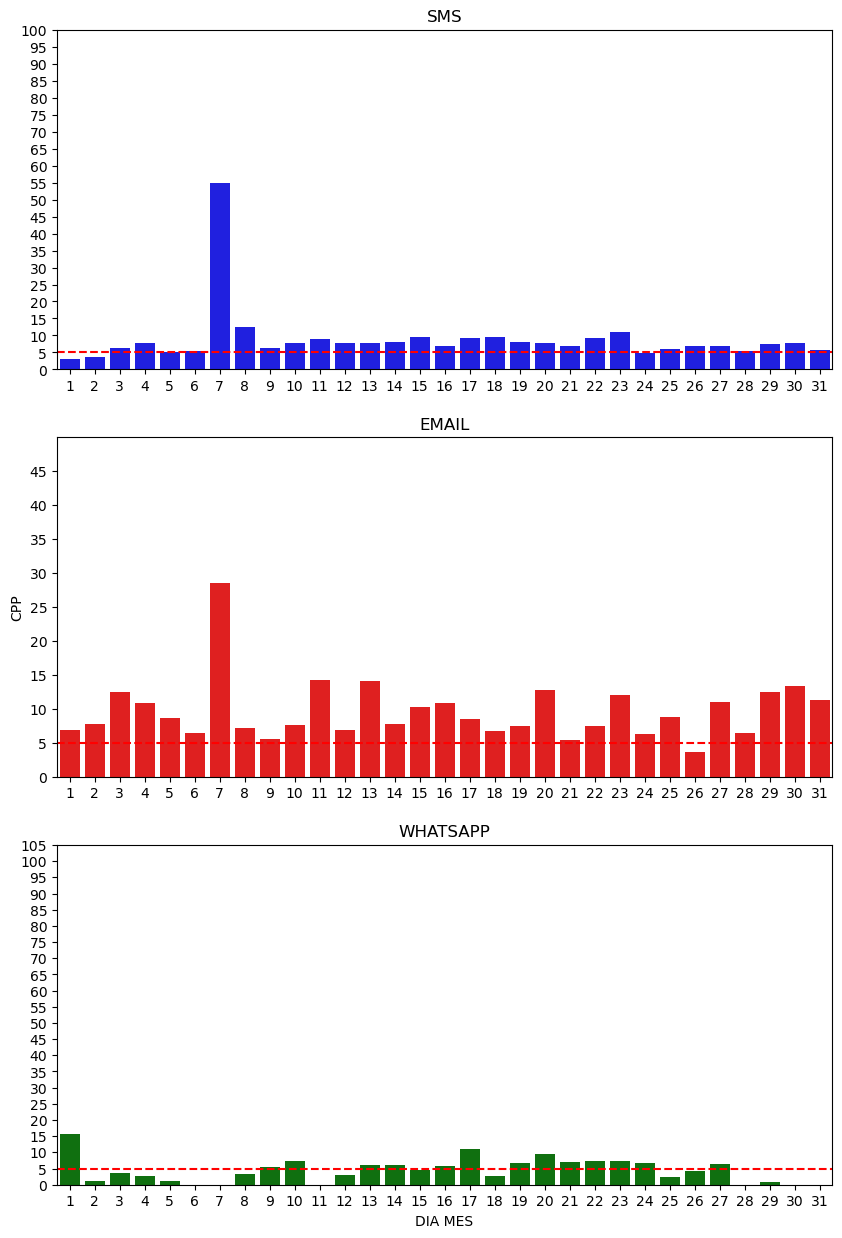

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
#SMS
sns.barplot(x=KPI_Canal_grouped['Dia_mes'], y=KPI_Canal_grouped[KPI_Canal_grouped['medium'] == 'SMS']['CPP'], ax=axs[0], color='blue')
axs[0].set_title('SMS')
axs[0].set_xlabel('') 
axs[0].set_ylabel('')
axs[0].set_ylim(0, 100)
axs[0].yaxis.set_ticks(range(0, 101, 5))
axs[0].axhline(y=5, color='r', linestyle='--') 
#EMAIL
sns.barplot(x=KPI_Canal_grouped['Dia_mes'], y=KPI_Canal_grouped[KPI_Canal_grouped['medium']=='E-MAIL']['CPP'], ax=axs[1],color='red')
axs[1].set_title('EMAIL')
axs[1].set_xlabel('') 
axs[1].set_ylabel('CPP')
axs[1].set_ylim(0, 50)
axs[1].yaxis.set_ticks(range(0, 50, 5)) 
axs[1].axhline(y=5, color='r', linestyle='--')
#WHATS
sns.barplot(x=KPI_Canal_grouped['Dia_mes'], y=KPI_Canal_grouped[KPI_Canal_grouped['medium']=='WHATSAPP']['CPP'], ax=axs[2],color='green')
axs[2].set_title('WHATSAPP')
axs[2].set_xlabel('DIA MES') 
axs[2].set_ylabel('')
axs[2].set_ylim(0, 105)
axs[2].yaxis.set_ticks(range(0, 106, 5))
axs[2].axhline(y=5, color='r', linestyle='--');

Melhores Períodos para Estímulo por Canal Sob Ótica do CPP:

SMS - 3, 9, 10, 28, 29

E-MAIL - 2, 7, 14, 24, 31

WHATSAPP - 3, 7, 20, 28, 29

## Faixa de Atraso

In [ ]:
KPI_FA = '''
select 
created_at,
producao.cod_cluster,
producao.faixa_atraso,
case when promessas is null then 0::float else promessas::float end promessas,
case when custo is null then 0::float else custo::float end custo
from (
select 
created_at,
d.cod_cluster,
coalesce(d.de,0) || ' a ' || coalesce(d.ate,0) as faixa_atraso,
count(distinct analitico_producao_37.deal_id) promessas
from quiteja_dados.analitico_producao_37
join quiteja_dados.dimensoes d on analitico_producao_37.days_of_delay between coalesce(d.de,0) and coalesce(d.ate,999999) and d.creditor_id = 37 and d.tipo_cluster = 'Atraso'
where 1=1
and date(analitico_producao_37.created_at) > date '2023-01-01' 
group by 1,2,3) producao
left join 
(select 
sent_at,
d.cod_cluster,
coalesce(d.de,0) || ' a ' || coalesce(d.ate,0) as faixa_atraso,
sum(1 * approach_cost) custo
from quiteja_dados.analitico_estimulos_37
join quiteja_lake.firing f on f.id = analitico_estimulos_37.firing_id 
join quiteja_dados.dimensoes d on analitico_estimulos_37.days_of_delay between coalesce(d.de,0) and coalesce(d.ate,999999) and d.creditor_id = 37 and d.tipo_cluster = 'Atraso'
where date(sent_at) > '2023-01-01' 
group by 1,2,3) custo on custo.sent_at = producao.created_at and producao.cod_cluster = custo.cod_cluster
order by 1,2
'''

In [ ]:
KPI_FA = sql_df(KPI_FA)
KPI_FA['created_at'] = pd.to_datetime(KPI_FA['created_at'])

In [ ]:
KPI_FA['CPP'] = KPI_FA['custo'] / KPI_FA['promessas']

In [ ]:
KPI_FA['Dia_mes'] = KPI_FA['created_at'].dt.day

In [ ]:
KPI_FA_grouped = KPI_FA.groupby(by=['Dia_mes', 'cod_cluster','faixa_atraso']).agg({'CPP':'mean'}).reset_index()

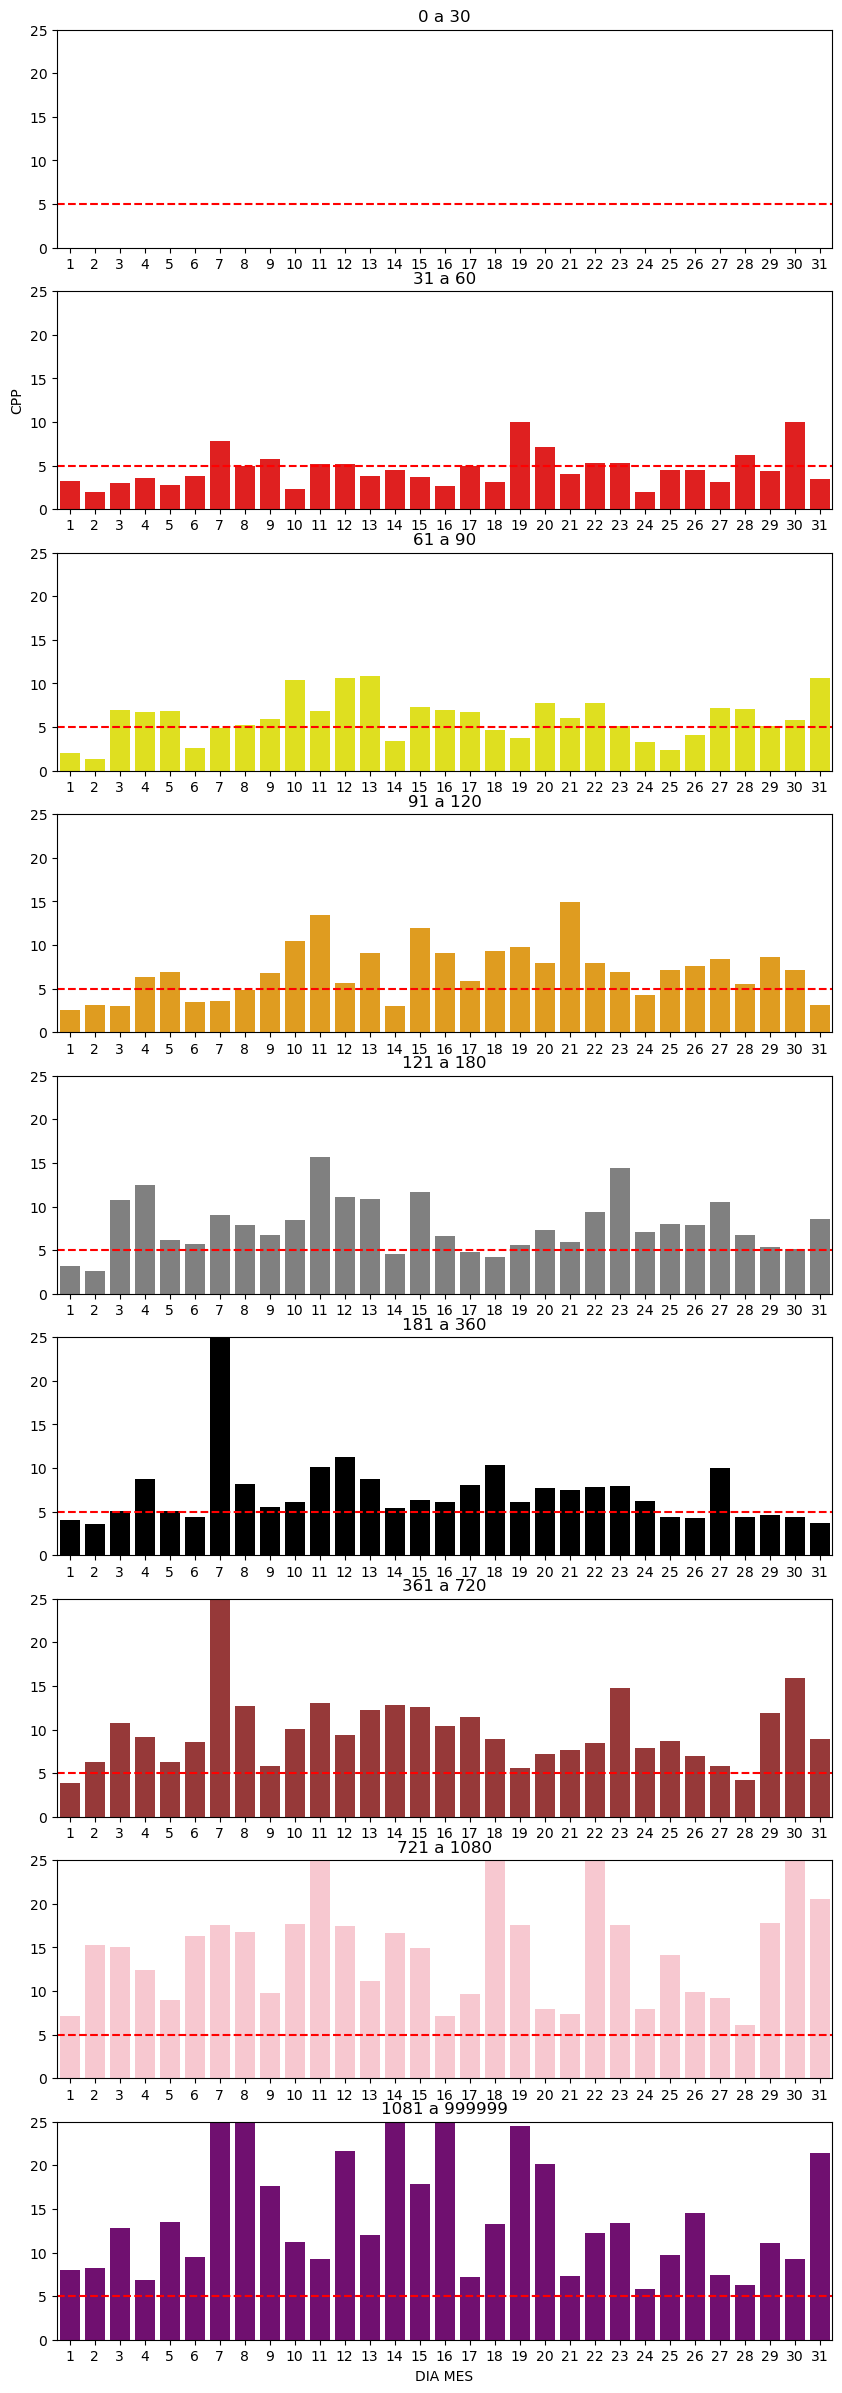

In [ ]:
fig, axs = plt.subplots(9, 1, figsize=(10, 30))
#0 a 30
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster'] == 1]['CPP'], ax=axs[0], color='blue')
axs[0].set_title('0 a 30')
axs[0].set_xlabel('') 
axs[0].set_ylabel('')
axs[0].set_ylim(0, 25)
axs[0].yaxis.set_ticks(range(0, 26, 5))
axs[0].axhline(y=5, color='r', linestyle='--') 
#31 a 60
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==2]['CPP'], ax=axs[1],color='red')
axs[1].set_title('31 a 60')
axs[1].set_xlabel('') 
axs[1].set_ylabel('CPP')
axs[1].set_ylim(0, 25)
axs[1].yaxis.set_ticks(range(0, 26, 5)) 
axs[1].axhline(y=5, color='r', linestyle='--')
#61 a 90
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==3]['CPP'], ax=axs[2],color='yellow')
axs[2].set_title('61 a 90')
axs[2].set_xlabel('') 
axs[2].set_ylabel('')
axs[2].set_ylim(0, 25)
axs[2].yaxis.set_ticks(range(0, 26, 5)) 
axs[2].axhline(y=5, color='r', linestyle='--')
#91 a 120
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==4]['CPP'], ax=axs[3],color='orange')
axs[3].set_title('91 a 120')
axs[3].set_xlabel('') 
axs[3].set_ylabel('')
axs[3].set_ylim(0, 25)
axs[3].yaxis.set_ticks(range(0, 26, 5)) 
axs[3].axhline(y=5, color='r', linestyle='--')
#121 a 180
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==5]['CPP'], ax=axs[4],color='gray')
axs[4].set_title('121 a 180')
axs[4].set_xlabel('') 
axs[4].set_ylabel('')
axs[4].set_ylim(0, 25)
axs[4].yaxis.set_ticks(range(0, 26, 5)) 
axs[4].axhline(y=5, color='r', linestyle='--')
#181 a 360	
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==6]['CPP'], ax=axs[5],color='black')
axs[5].set_title('181 a 360')
axs[5].set_xlabel('') 
axs[5].set_ylabel('')
axs[5].set_ylim(0, 25)
axs[5].yaxis.set_ticks(range(0, 26, 5)) 
axs[5].axhline(y=5, color='r', linestyle='--');
#361 a 720
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==7]['CPP'], ax=axs[6],color='brown')
axs[6].set_title('361 a 720')
axs[6].set_xlabel('') 
axs[6].set_ylabel('')
axs[6].set_ylim(0, 25)
axs[6].yaxis.set_ticks(range(0, 26, 5)) 
axs[6].axhline(y=5, color='r', linestyle='--')
#721 a 1080
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==8]['CPP'], ax=axs[7],color='pink')
axs[7].set_title('721 a 1080')
axs[7].set_xlabel('') 
axs[7].set_ylabel('')
axs[7].set_ylim(0, 25)
axs[7].yaxis.set_ticks(range(0, 26, 5)) 
axs[7].axhline(y=5, color='r', linestyle='--')
#1081 a 0	
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==9]['CPP'], ax=axs[8],color='purple')
axs[8].set_title('1081 a 999999')
axs[8].set_xlabel('DIA MES') 
axs[8].set_ylabel('')
axs[8].set_ylim(0, 25)
axs[8].yaxis.set_ticks(range(0, 26, 5)) 
axs[8].axhline(y=5, color='r', linestyle='--');

Melhores Períodos para Estímulo por Faixa de Atraso Sob Ótica do CPP:

181 - 360 - 9, 23, 31

121 - 180 - 7, 9, 17, 29


Melhores Períodos para Estímulo por Canal e Faixa de Atraso Sob Ótica do CPP:

SMS (181 - 360) 9, 10

E-MAIL (181 - 360) - 31

SMS (121 - 180) - 9, 10, 28, 29

E-MAIL (121 - 180) - 7

WHATSAPP (121 - 180) - 7, 29


In [ ]:
KPI_CPL = ''' 

select 
f.created_at, 
approach_type,
case when sum(notifications * approach_cost) = 0 or sum(localized) = 0 then 0 else sum(notifications * approach_cost) / sum(localized)::float end CPL
from quiteja_lake.firing f 
where creditor_id = 37 and strategy_public != 'LOCATED'
group by 1,2

'''

In [ ]:
KPI_CPL = sql_df(KPI_CPL)

In [ ]:
KPI_CPL['created_at'] = pd.to_datetime(KPI_CPL['created_at'])
KPI_CPL['Dia_mes'] = KPI_CPL['created_at'].dt.day

In [ ]:
KPI_CPL_grouped = KPI_CPL.groupby(by=['Dia_mes', 'approach_type']).agg({'cpl':'mean'}).reset_index()

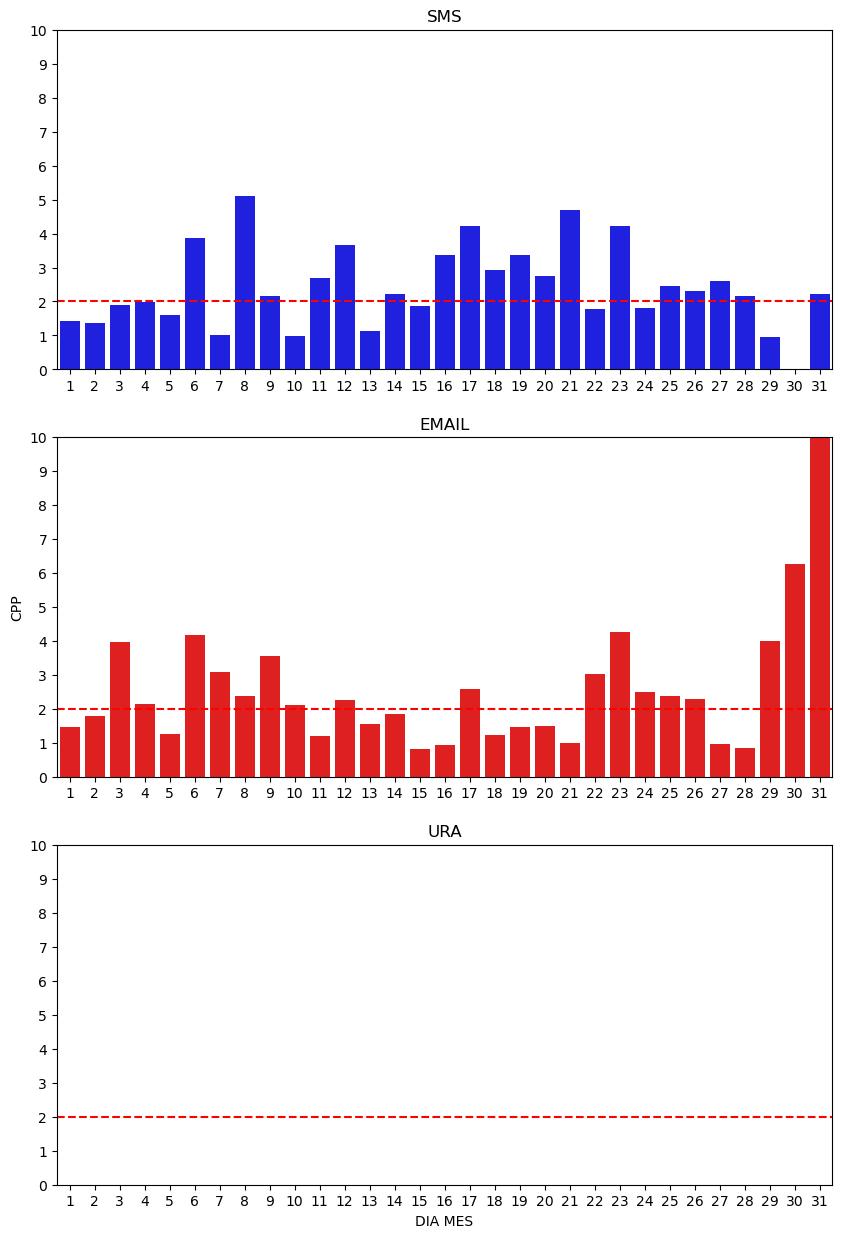

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
#SMS
sns.barplot(x=KPI_CPL_grouped['Dia_mes'], y=KPI_CPL_grouped[KPI_CPL_grouped['approach_type'] == 'SMS']['cpl'], ax=axs[0], color='blue')
axs[0].set_title('SMS')
axs[0].set_xlabel('') 
axs[0].set_ylabel('')
axs[0].set_ylim(0, 10)
axs[0].yaxis.set_ticks(range(0, 11, 1))
axs[0].axhline(y=2, color='r', linestyle='--') 
#EMAIL
sns.barplot(x=KPI_CPL_grouped['Dia_mes'], y=KPI_CPL_grouped[KPI_CPL_grouped['approach_type']=='EMAIL']['cpl'], ax=axs[1],color='red')
axs[1].set_title('EMAIL')
axs[1].set_xlabel('') 
axs[1].set_ylabel('CPP')
axs[1].set_ylim(0, 10)
axs[1].yaxis.set_ticks(range(0, 11, 1)) 
axs[1].axhline(y=2, color='r', linestyle='--')
#WHATS
sns.barplot(x=KPI_CPL_grouped['Dia_mes'], y=KPI_CPL_grouped[KPI_CPL_grouped['approach_type']=='CALL_CELLPHONE']['cpl'], ax=axs[2],color='green')
axs[2].set_title('URA')
axs[2].set_xlabel('DIA MES') 
axs[2].set_ylabel('')
axs[2].set_ylim(0, 10)
axs[2].yaxis.set_ticks(range(0, 11, 1))
axs[2].axhline(y=2, color='r', linestyle='--');

Melhores Períodos para Estímulo por Canal Sob Ótica do CPL:

URA - 10, 16 

SMS - 7, 11 até 16

EMAIL - Durante todo mês

# CONCLUSÃO 

O estudo foi realizado levando em consideração dados de estímulos desse ano, e dados de produção de 2023 para frente. 

Análise foi realizada em cima das faixas de atraso e trouxe 3 visões:

Produção

Estimulos

Distribuição da carteira.

E a conclusão é que pode ter um espaço para melhoria de performace trabalhando melhor as faixas de atraso de 181-360 e 121-180, os indicativos são:


1) Olhando para produção desse ano foi possível ver que as faixas que mais produziram foi de 181-360, 361-720, e 121-180. Além de que na média possuem um valor de operação aproximado da maior frequencia de valor de operação da produção geral.

2) Ainda sobre produção, foi possível notar que essas faixas produzem muito bem em SMS, Email e Whats. Porém a maior frequência de produção é SMS.

In [ ]:
(pd.crosstab(producao['medium'], producao['faixa_atraso'], normalize=True) * 100).style.background_gradient(axis=1, cmap='YlOrRd')

faixa_atraso,1096 a 1825,121 a 180,181 a 360,1826 a 0,31 a 60,361 a 1095,61 a 90,91 a 120
medium,,,,,,,,
E-MAIL,1.192022,1.310044,3.174791,0.660923,2.832527,5.251977,1.404461,0.802549
ORGANICO,0.342264,0.389472,1.192022,0.318659,0.566505,1.852945,0.460286,0.177033
PUSH,0.354066,0.448483,0.979582,0.295055,0.778945,1.546088,0.377670,0.330461
SMS,3.646878,5.204768,15.838546,2.584681,13.301074,15.224832,7.388174,3.953735
URA,0.000000,0.000000,0.000000,0.000000,0.000000,0.011802,0.000000,0.000000
WHATSAPP,0.129824,0.483890,1.321846,0.271450,0.908769,1.605099,0.637319,0.448483


3) Foi possível verificar que as faixas de atraso 121-180 e 181-360 não foram tão estimuladas quanto a de 361-720, portanto tem espaço para crescimento ainda.


In [ ]:
pd.DataFrame((estimulos['faixa_atraso'].value_counts(normalize=True) * 100).sort_values(ascending=False)).style.background_gradient(axis=0, cmap='YlOrRd')

,faixa_atraso
361 a 1095,42.450943
1096 a 1825,15.198157
181 a 360,14.783381
1826 a 999999,8.555683
31 a 60,6.415204
121 a 180,5.108487
61 a 90,4.299817
91 a 120,3.188329


In [ ]:
(pd.crosstab(estimulos['approach_type'], estimulos['faixa_atraso'], normalize=True) * 100).style.background_gradient(axis=1, cmap='YlOrRd')

faixa_atraso,1096 a 1825,121 a 180,181 a 360,1826 a 999999,31 a 60,361 a 1095,61 a 90,91 a 120
approach_type,,,,,,,,
EMAIL,5.710492,2.064815,5.647920,3.251867,2.458970,18.887961,1.789082,1.368415
PUSH,8.437287,2.214623,6.607172,4.492028,2.573492,20.084483,1.587534,1.248287
SMS,1.048160,0.819536,2.505844,0.806149,1.372171,3.457490,0.910167,0.565744
WHATSAPP,0.002219,0.009513,0.022446,0.005639,0.010572,0.021009,0.013034,0.005882


4) Ambas possuem uma representatividade Ok na base 181-360 (18.45%) e 121-180 (5.11%), sendo a segunda e a quarta faixa de atraso com mais represatividade. 


In [ ]:
pd.DataFrame({'Tamanho Base': (con_deal['faixa_atraso'].value_counts(normalize=True) * 100).apply('{:.2f}%'.format)})

,Tamanho Base
361 a 1095,51.84%
1096 a 1825,21.72%
181 a 360,11.93%
121 a 180,5.36%
31 a 60,3.71%
61 a 90,2.75%
91 a 120,2.69%


Ainda como uma análise complementar indico acionar essas faixas e canais nesses determinados dias (com base no CPP):

Melhores Períodos para Estímulo por Canal Sob Ótica do CPP:

SMS - 3, 9, 10, 28, 29

E-MAIL - 2, 7, 14, 24, 31

WHATSAPP - 3, 7, 20, 28, 29

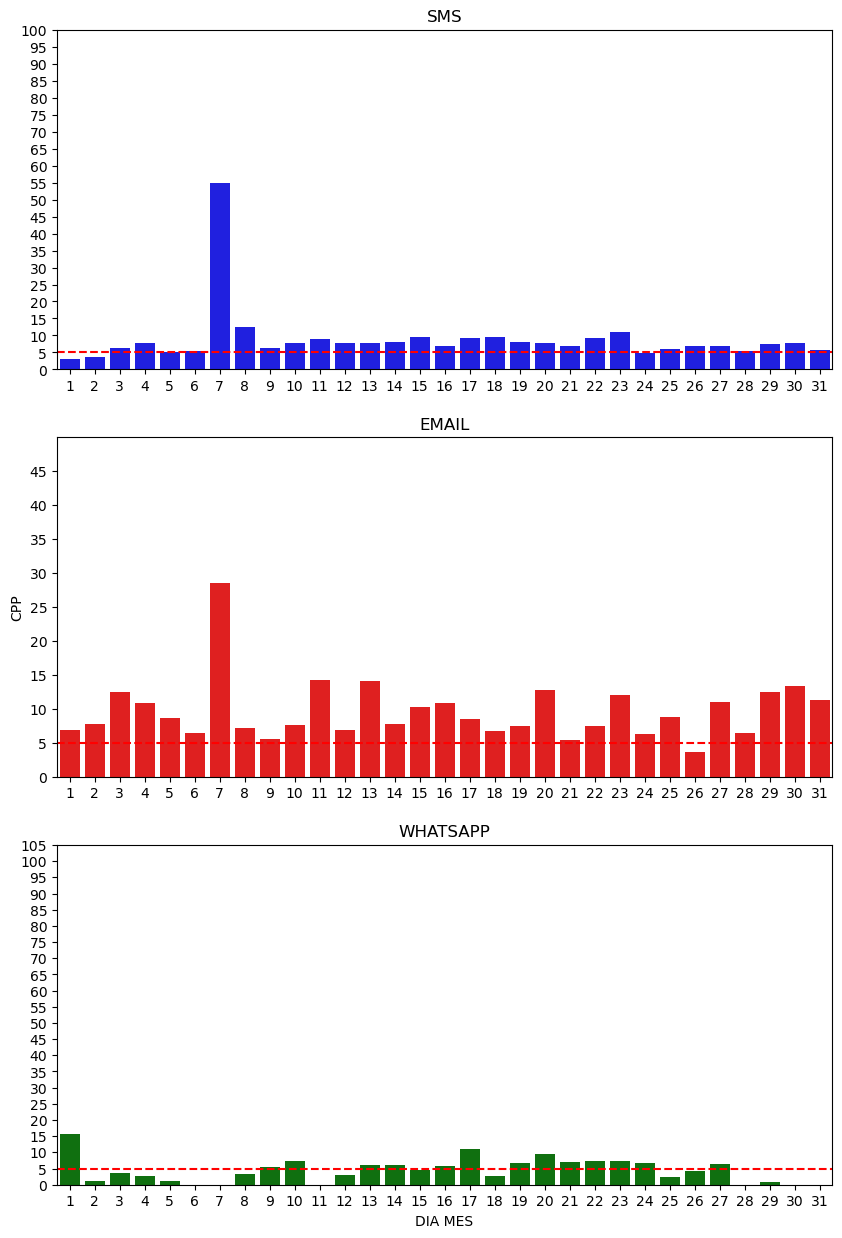

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
#SMS
sns.barplot(x=KPI_Canal_grouped['Dia_mes'], y=KPI_Canal_grouped[KPI_Canal_grouped['medium'] == 'SMS']['CPP'], ax=axs[0], color='blue')
axs[0].set_title('SMS')
axs[0].set_xlabel('') 
axs[0].set_ylabel('')
axs[0].set_ylim(0, 100)
axs[0].yaxis.set_ticks(range(0, 101, 5))
axs[0].axhline(y=5, color='r', linestyle='--') 
#EMAIL
sns.barplot(x=KPI_Canal_grouped['Dia_mes'], y=KPI_Canal_grouped[KPI_Canal_grouped['medium']=='E-MAIL']['CPP'], ax=axs[1],color='red')
axs[1].set_title('EMAIL')
axs[1].set_xlabel('') 
axs[1].set_ylabel('CPP')
axs[1].set_ylim(0, 50)
axs[1].yaxis.set_ticks(range(0, 50, 5)) 
axs[1].axhline(y=5, color='r', linestyle='--')
#WHATS
sns.barplot(x=KPI_Canal_grouped['Dia_mes'], y=KPI_Canal_grouped[KPI_Canal_grouped['medium']=='WHATSAPP']['CPP'], ax=axs[2],color='green')
axs[2].set_title('WHATSAPP')
axs[2].set_xlabel('DIA MES') 
axs[2].set_ylabel('')
axs[2].set_ylim(0, 105)
axs[2].yaxis.set_ticks(range(0, 106, 5))
axs[2].axhline(y=5, color='r', linestyle='--');

Melhores Períodos para Estímulo por Faixa de Atraso Sob Ótica do CPP:

121 - 180 - 3, 7, 9, 17, 28, 29

181 - 360 - 9, 23, 31


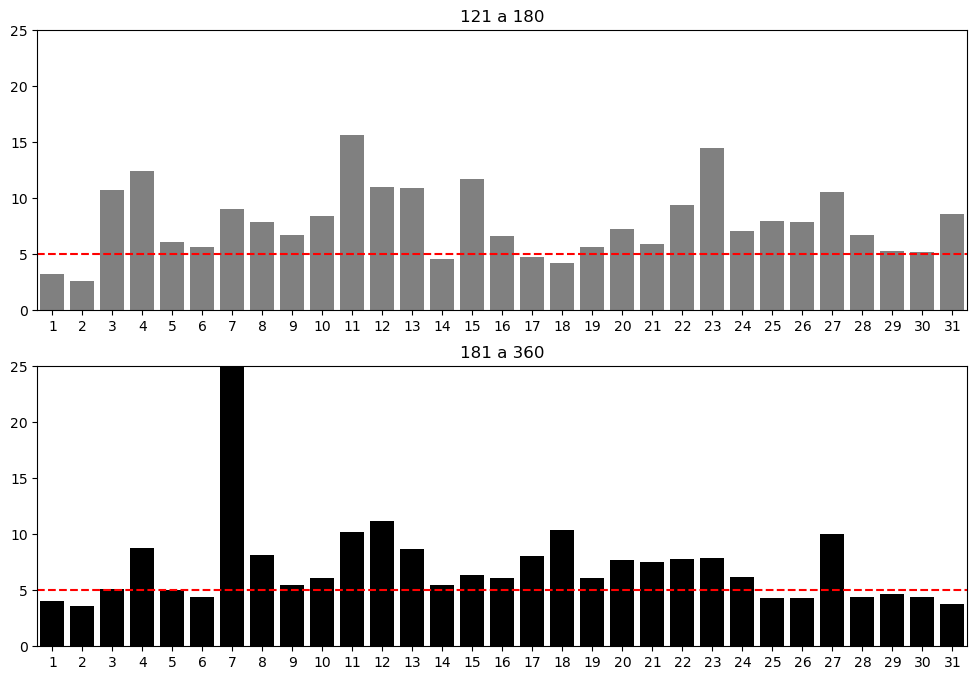

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
#121 a 180
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==5]['CPP'], ax=axs[0],color='gray')
axs[0].set_title('121 a 180')
axs[0].set_xlabel('') 
axs[0].set_ylabel('')
axs[0].set_ylim(0, 25)
axs[0].yaxis.set_ticks(range(0, 26, 5)) 
axs[0].axhline(y=5, color='r', linestyle='--')
#181 a 360	
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==6]['CPP'], ax=axs[1],color='black')
axs[1].set_title('181 a 360')
axs[1].set_xlabel('') 
axs[1].set_ylabel('')
axs[1].set_ylim(0, 25)
axs[1].yaxis.set_ticks(range(0, 26, 5)) 
axs[1].axhline(y=5, color='r', linestyle='--');

Melhores Períodos para Estímulo por Canal e Faixa de Atraso Sob Ótica do CPP:

SMS (181 - 360) 9, 10

E-MAIL (181 - 360) - 31

SMS (121 - 180) - 9, 10, 28, 29

E-MAIL (121 - 180) - 7

WHATSAPP (121 - 180) - 7, 29

***

Pensando em renovação de balde, foi possível averiguar que esses são os melhores dias para explorar os não localizados > 

Melhores Períodos para Estímulo por Canal Sob Ótica do CPL:

URA - 10, 16 

SMS - 7, 11 até 16

EMAIL - Durante todo mês

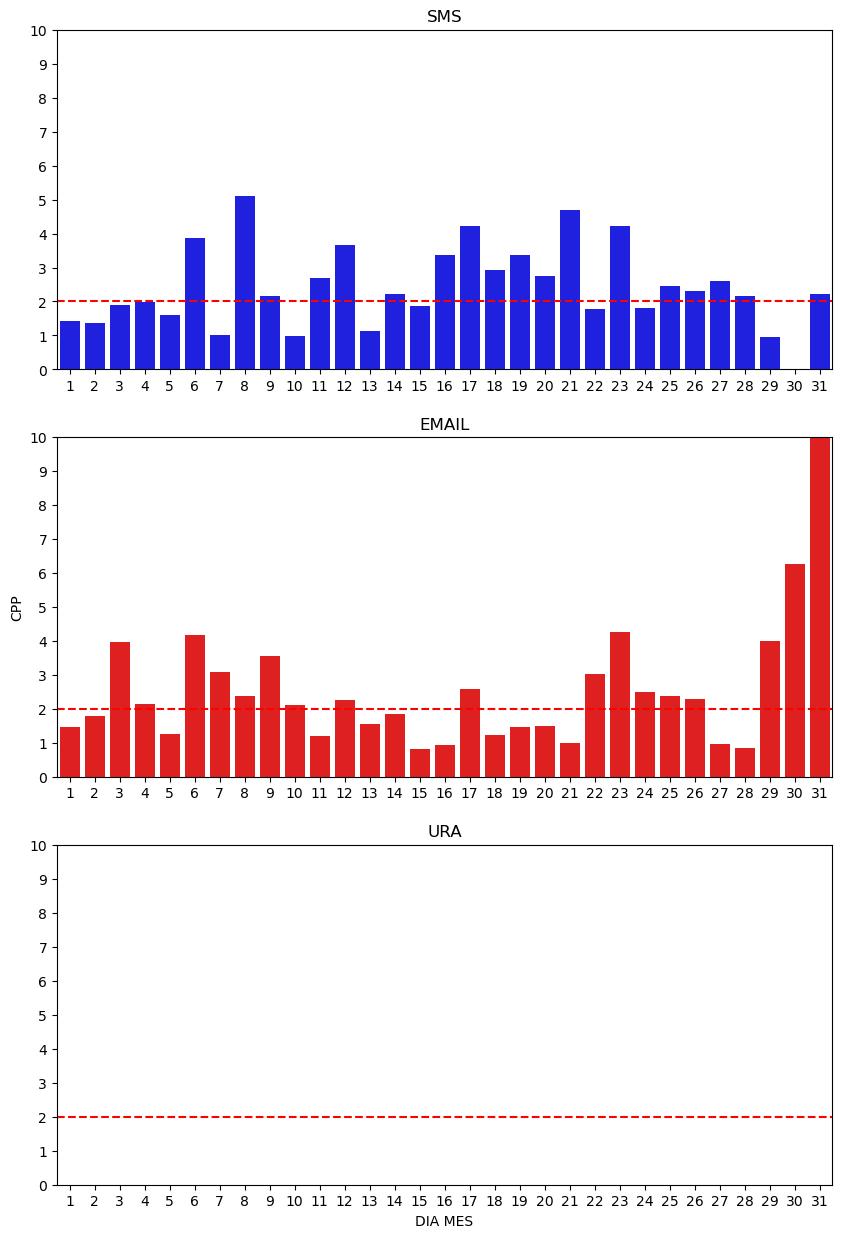

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
#SMS
sns.barplot(x=KPI_CPL_grouped['Dia_mes'], y=KPI_CPL_grouped[KPI_CPL_grouped['approach_type'] == 'SMS']['cpl'], ax=axs[0], color='blue')
axs[0].set_title('SMS')
axs[0].set_xlabel('') 
axs[0].set_ylabel('')
axs[0].set_ylim(0, 10)
axs[0].yaxis.set_ticks(range(0, 11, 1))
axs[0].axhline(y=2, color='r', linestyle='--') 
#EMAIL
sns.barplot(x=KPI_CPL_grouped['Dia_mes'], y=KPI_CPL_grouped[KPI_CPL_grouped['approach_type']=='EMAIL']['cpl'], ax=axs[1],color='red')
axs[1].set_title('EMAIL')
axs[1].set_xlabel('') 
axs[1].set_ylabel('CPP')
axs[1].set_ylim(0, 10)
axs[1].yaxis.set_ticks(range(0, 11, 1)) 
axs[1].axhline(y=2, color='r', linestyle='--')
#WHATS
sns.barplot(x=KPI_CPL_grouped['Dia_mes'], y=KPI_CPL_grouped[KPI_CPL_grouped['approach_type']=='CALL_CELLPHONE']['cpl'], ax=axs[2],color='green')
axs[2].set_title('URA')
axs[2].set_xlabel('DIA MES') 
axs[2].set_ylabel('')
axs[2].set_ylim(0, 10)
axs[2].yaxis.set_ticks(range(0, 11, 1))
axs[2].axhline(y=2, color='r', linestyle='--');

Uma sugestão futura é um possível enriquecimento na base de E-mail, visto que é uma base boa para trabalhar pensando em renovação de balde, porém é uma base pequena (cerca de 5% do público total é não localizado e possui Email). 

In [ ]:
round(pd.crosstab(consolidacao['contact_status'], consolidacao['contact_type'],  normalize=True) * 100,2)

contact_type,CELLPHONE,DEVICE_TOKEN,EMAIL
contact_status,,,
CONFIRMED,31.66,6.23,7.77
CREATED,50.41,0.00,3.89
UNAVAILABLE,0.04,0.00,0.00


## Faixa Débito

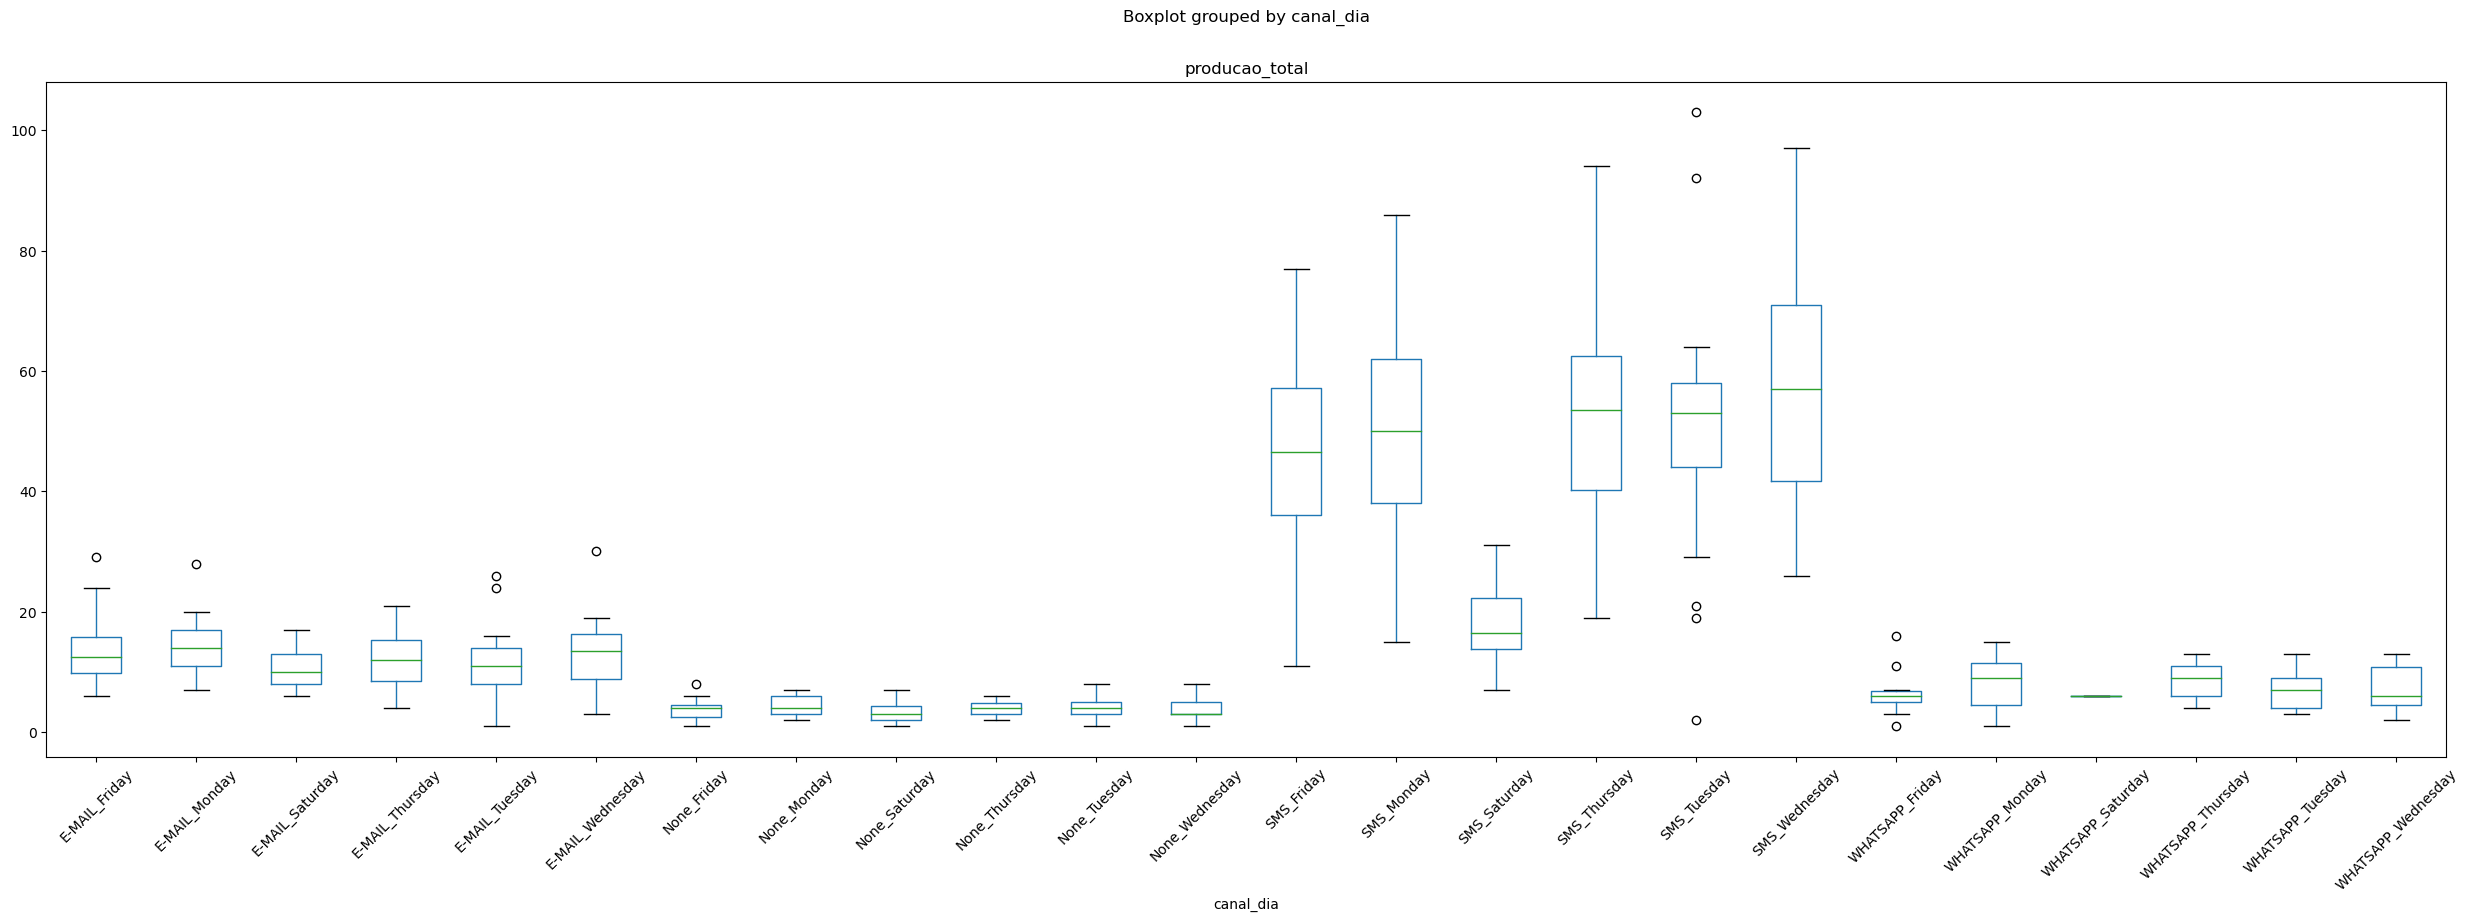

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(30, 9))
cpp_corr.boxplot(by='canal_dia', column='producao_total', grid=False, ax=ax1)
plt.xticks(rotation=45);

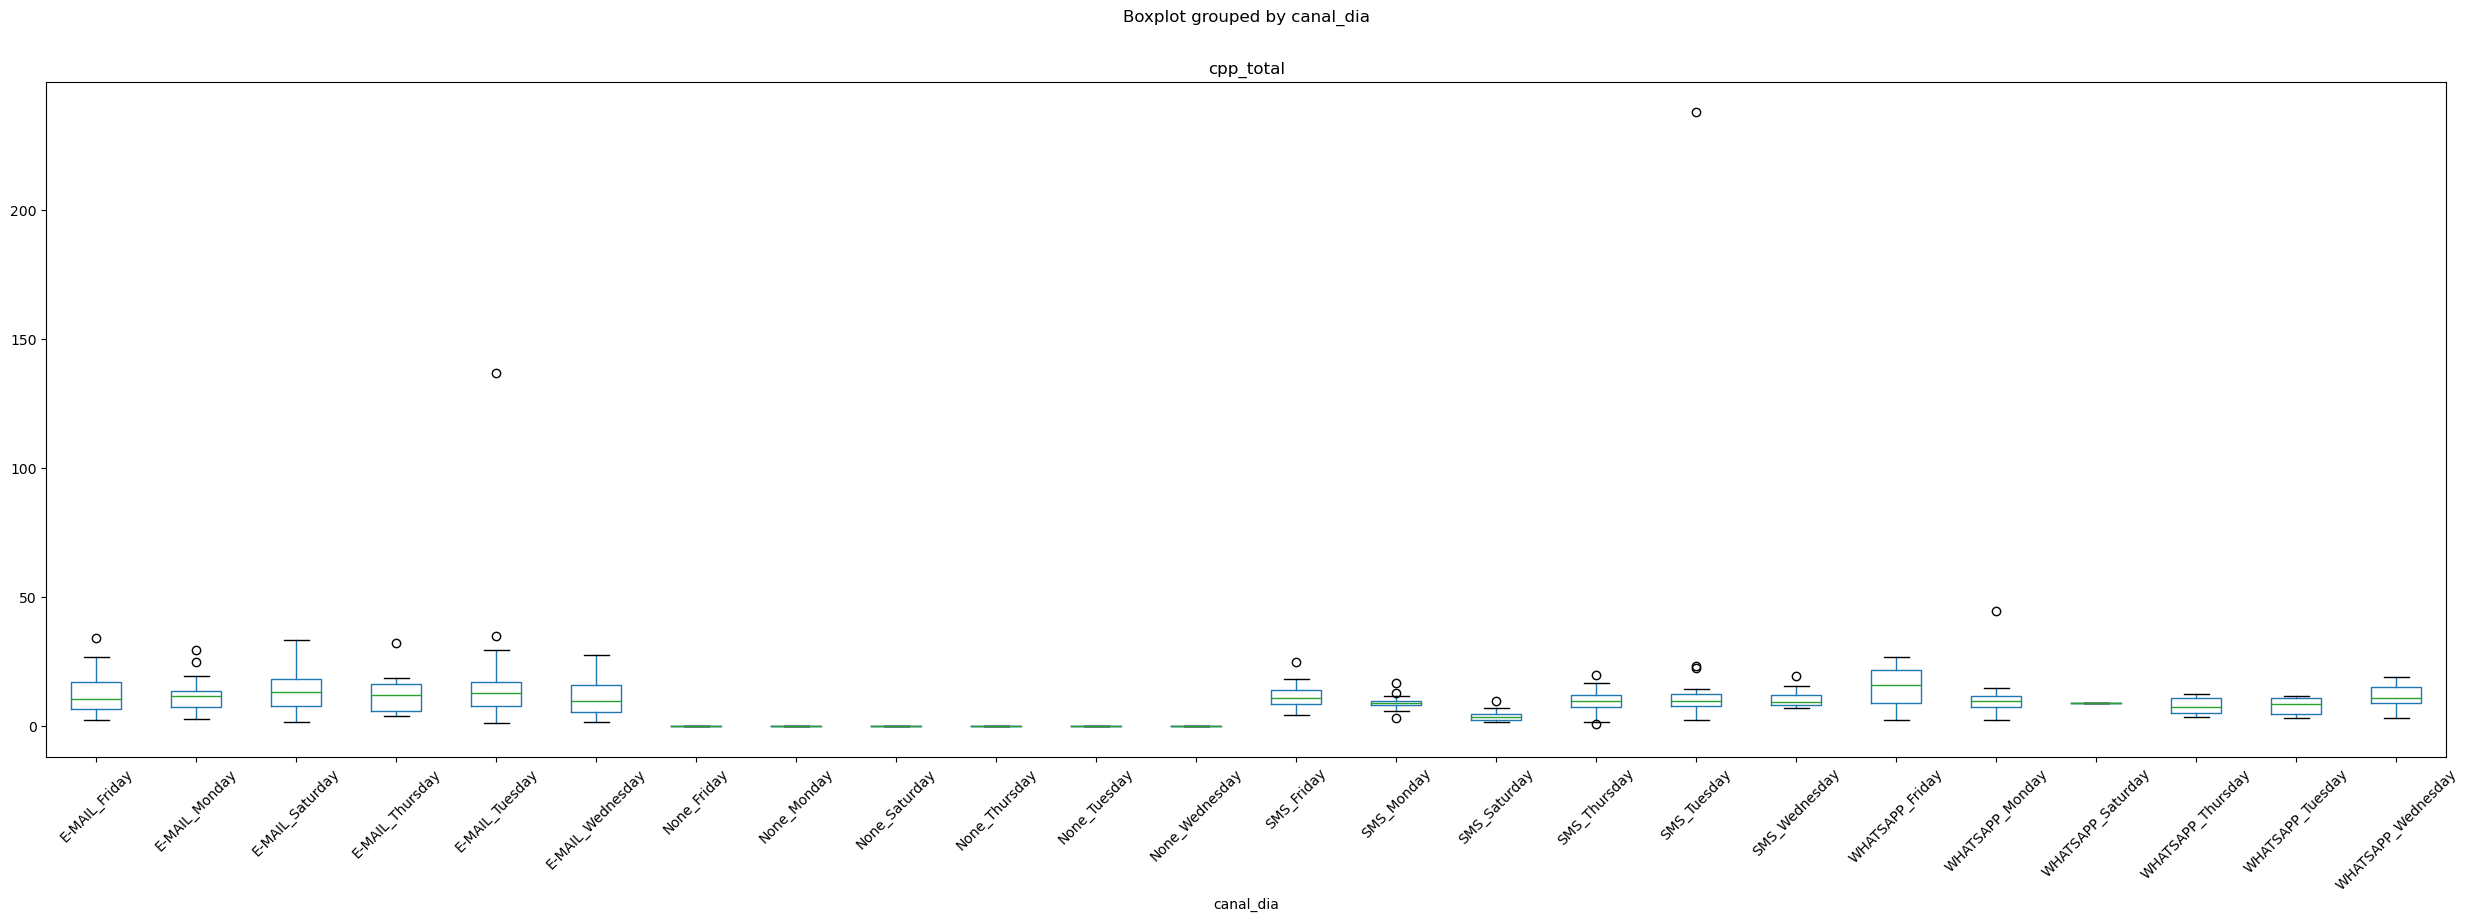

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(30, 9))
cpp_corr.boxplot(by='canal_dia', column='cpp_total', grid=False, ax=ax1)
plt.xticks(rotation=45);

In [ ]:
cpp_group = cpp_corr.groupby(by='canal_dia').agg('sum','producao_total').reset_index()

In [ ]:
cpp_group

,canal_dia,producao_total,cpp_total
0,E-MAIL_Friday,224,204.061675
1,E-MAIL_Monday,246,200.647160
2,E-MAIL_Saturday,190,258.722164
3,E-MAIL_Thursday,194,194.656738
4,E-MAIL_Tuesday,197,354.632986
5,E-MAIL_Wednesday,212,188.384724
6,None_Friday,70,0.000000
7,None_Monday,82,0.000000
8,None_Saturday,67,0.000000
9,None_Thursday,69,0.000000


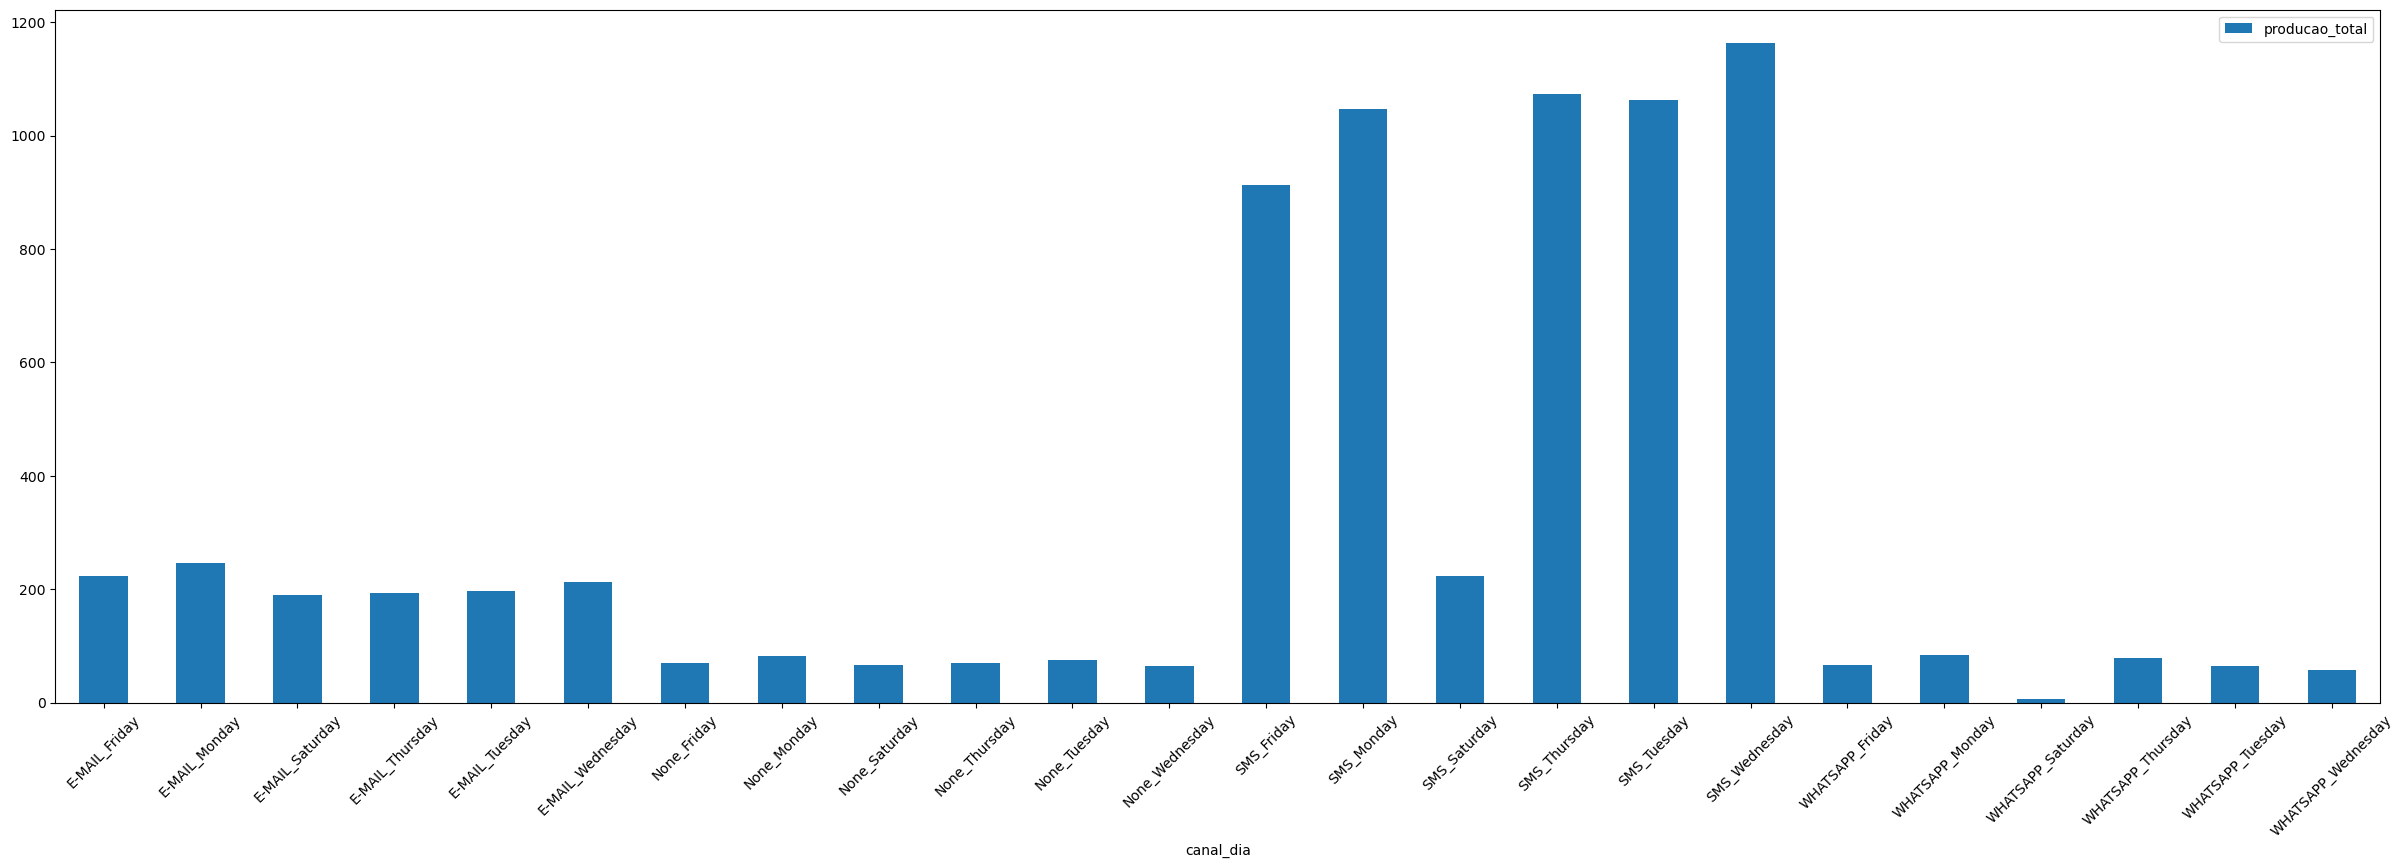

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(30, 9))
cpp_group.plot(kind='bar', x = 'canal_dia', y='producao_total', ax=ax1)
plt.xticks(rotation=45);

In [ ]:
cash_custo = ''' 
with cash as(
select
    p.creditor_id,
    payed_date::date,
    case when pm.medium = 'push' then 'PUSH'
    	 when pm.medium = 'whatsapp' then 'WHATSAPP'
    	 when pm.medium = 'sms' then 'SMS'
    	 when pm.medium = 'email' then 'EMAIL'
    	 else 'ORGANIC'
    	 end canal,
    sum(p.value * pot.fee) comissionado
from
                quiteja_lake.payment p
left join (
    select
        deal_id,
        max(days_of_delay) days_of_delay
    from
        quiteja_lake.operation o
    where
        o.active is true
    group by
        1) o on
                o.deal_id = p.deal_id
left join quiteja_lake.potential pot on    o.days_of_delay between coalesce(pot.min_days_of_delay,    0) and coalesce(pot.max_days_of_delay,    999999)
    and pot.active is true
    and pot.creditor_id = p.creditor_id
left join quiteja_lake.proposal pp on pp.deal_id = o.deal_id and pp.status = 'AGREED'
join quiteja_lake.proposal_marketing pm on pp.id = pm.proposal_id
where
                1 = 1
    and date(p.payed_date) between '2024-01-01'::date and current_date::date 
     and p.status = 'PAYED'
    and p.type = 'DOWN_PAYMENT'
    and p.creditor_id = '37'
group by
    1,2,3),
    
custo as (
select 
	created_at::date,
	approach_type,
    creditor_id,
    sum(notifications * approach_cost) custo_geral
from
    quiteja_lake.firing
where 
    created_at::date  between '2024-01-01'::date and current_date::date 
    and creditor_id = 37
group by 1,2,3)


select 
created_at,
approach_type,
case when custo_geral = 0 then comissionado else comissionado  / custo_geral::float end cash_custo
from cash
join custo on cash.canal = custo.approach_type and custo.created_at = cash.payed_date
where approach_type not in ('ORGANIC', 'PUSH')
order by 1, 2 desc


'''

In [ ]:
cash_custo = sql_df(cash_custo)
cash_custo['created_at'] = pd.to_datetime(cash_custo['created_at'])

In [ ]:
cash_custo['Dia'] = cash_custo['created_at'].dt.day_name()

In [ ]:
cash_custo

,created_at,approach_type,cash_custo,Dia
0,2024-01-22,SMS,0.144255,Monday
1,2024-01-23,SMS,0.061840,Tuesday
2,2024-01-24,SMS,0.390113,Wednesday
3,2024-01-25,SMS,0.244074,Thursday
4,2024-01-26,SMS,0.294335,Friday
...,...,...,...,...
232,2024-06-15,SMS,1.242859,Saturday
233,2024-06-15,EMAIL,0.119191,Saturday
234,2024-06-17,WHATSAPP,0.793988,Monday
235,2024-06-17,SMS,0.292887,Monday


In [ ]:
anova_cc = ols('cash_custo ~ Dia * approach_type', data = cash_custo).fit()
resultado_anovacc = sm.stats.anova_lm(anova_cc)
resultado_anovacc

,df,sum_sq,mean_sq,F,PR(>F)
Dia,5.0,2.820564,0.564113,0.384532,0.859108
approach_type,2.0,10.932195,5.466097,3.726006,0.025622
Dia:approach_type,10.0,11.572606,1.157261,0.788855,0.639552
Residual,220.0,322.742752,1.467013,NaN,NaN


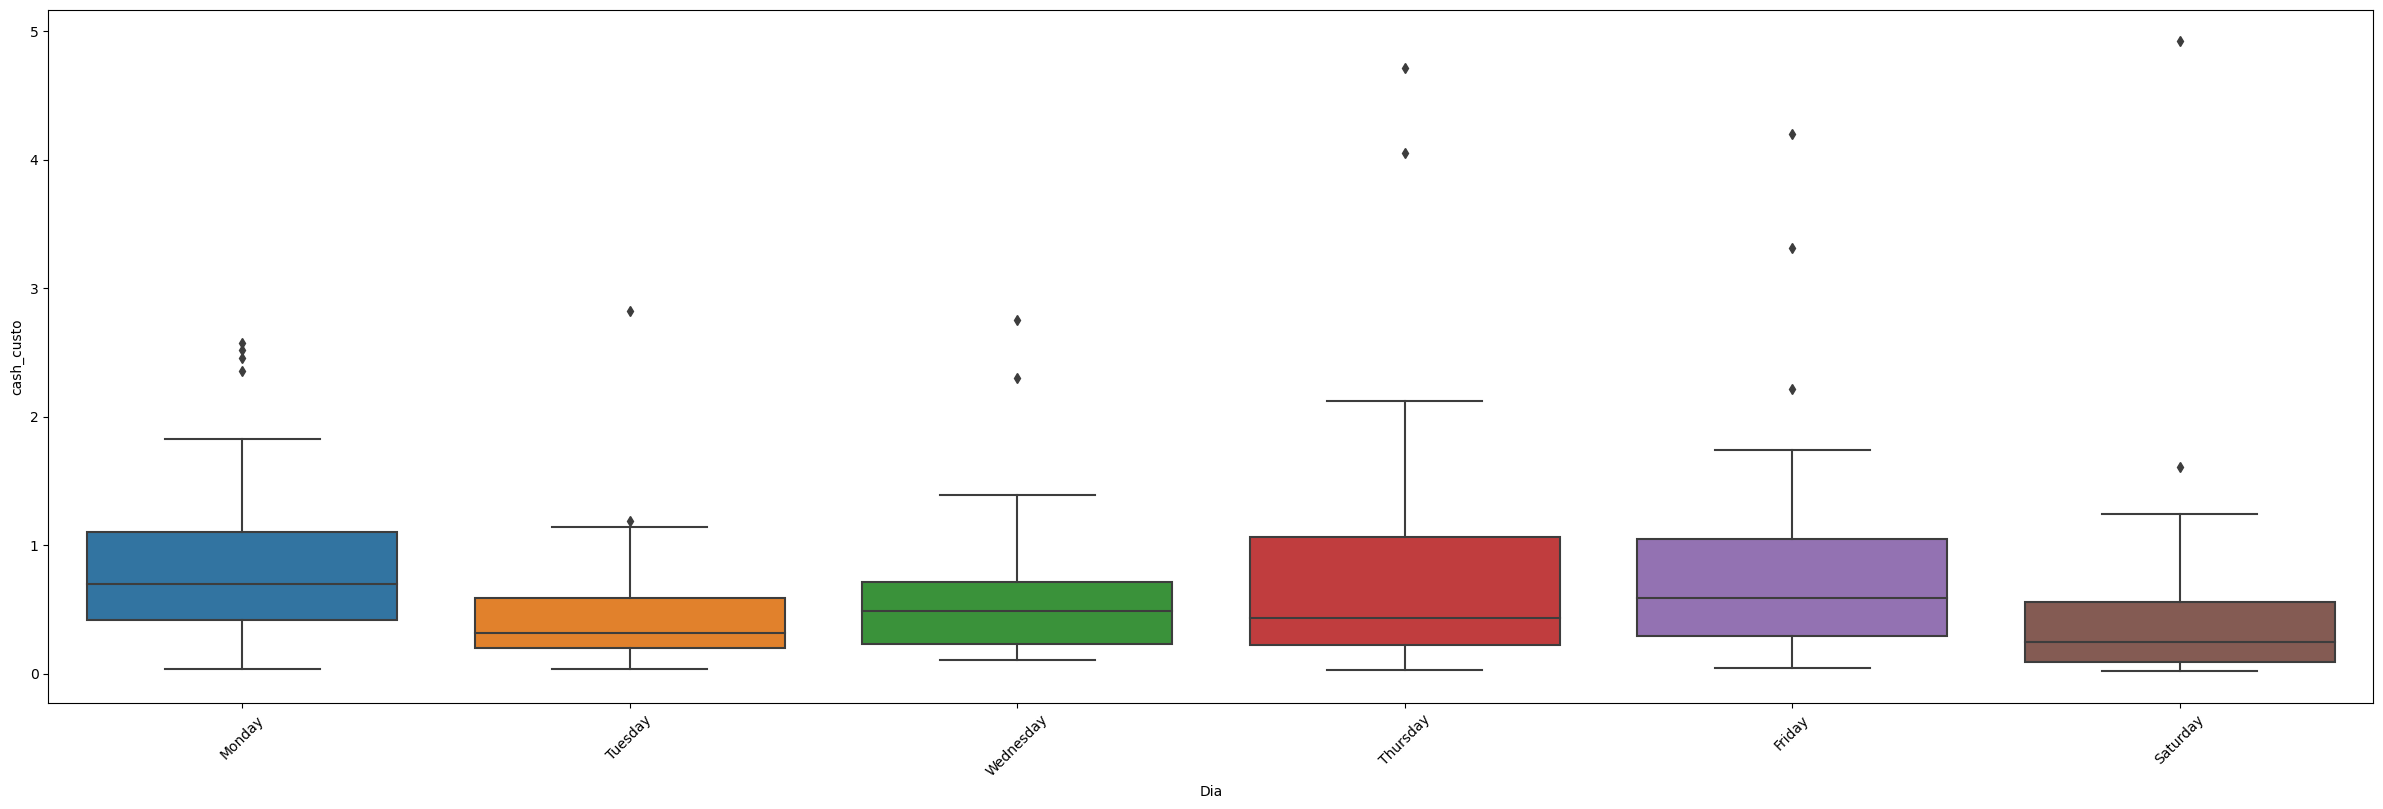

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(30, 9))
sns.boxplot(x='Dia', y='cash_custo', data=cash_custo[cash_custo['cash_custo'] < 5], ax=ax1)
plt.xticks(rotation=45);

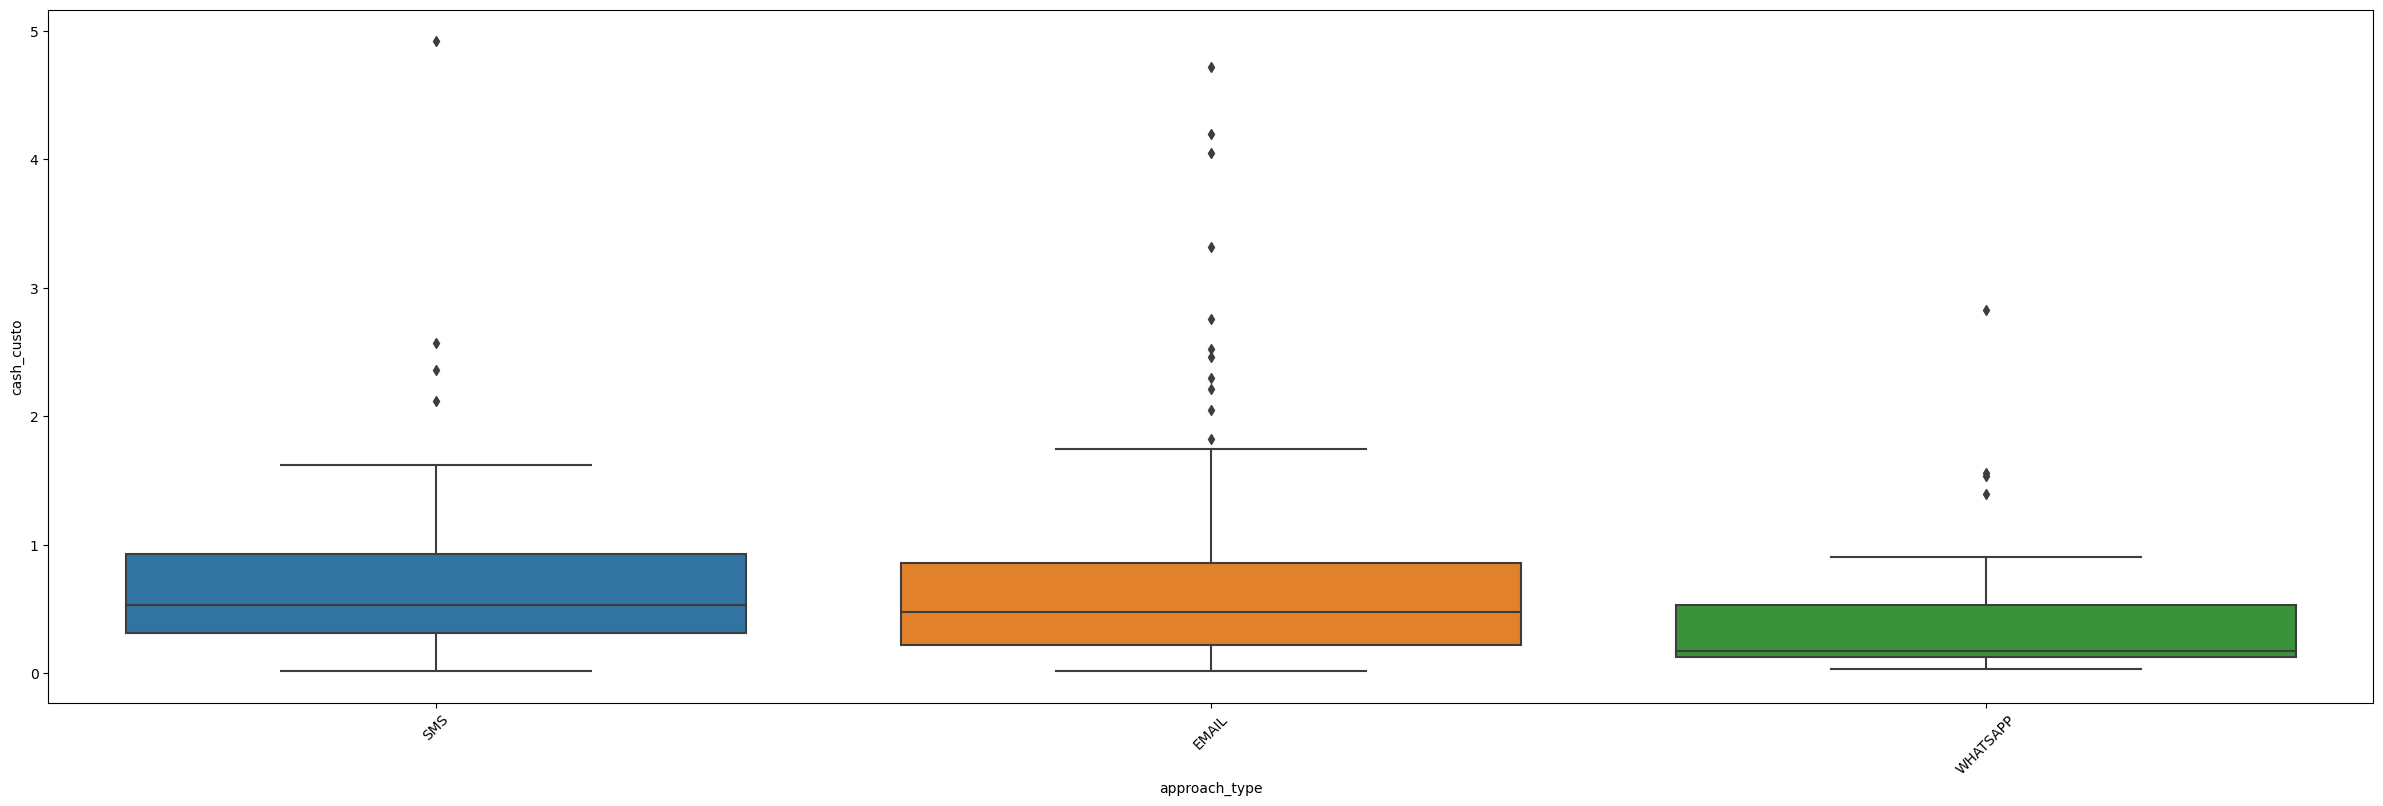

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(30, 9))
sns.boxplot(x='approach_type', y='cash_custo', data=cash_custo[cash_custo['cash_custo'] < 5], ax=ax1)
plt.xticks(rotation=45);

In [ ]:
tukey = pairwise_tukeyhsd(endog=cash_custo['cash_custo'], groups=cash_custo['approach_type'], alpha=0.05)

In [ ]:
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
EMAIL,SMS,-0.2481,0.3137,-0.6498,0.1536,False
EMAIL,WHATSAPP,-0.5976,0.0354,-1.1628,-0.0324,True
SMS,WHATSAPP,-0.3495,0.2926,-0.899,0.1999,False


In [ ]:
cc_valor_divida = ''' 
with cash as(
select
    p.creditor_id,
    to_char(payed_date::date,'YYYY-MM') payed_date,
    coalesce(de,0) || ' a ' || coalesce(ate, 999999) as valor_divida,
    sum(p.value * pot.fee) comissionado
from  quiteja_lake.payment p
left join (
    select
        deal_id,
        max(days_of_delay) days_of_delay,
       (o.principal_value + coalesce(o.interest_value,0) + coalesce(o.fee_value,0)) debt_value
    from
        quiteja_lake.operation o
    where
        o.active is true
    group by
        1,3) o on
                o.deal_id = p.deal_id
left join quiteja_lake.potential pot on    o.days_of_delay between coalesce(pot.min_days_of_delay,    0) and coalesce(pot.max_days_of_delay,    999999)
    and pot.active is true
    and pot.creditor_id = p.creditor_id
join quiteja_dados.dimensoes d on debt_value between coalesce(d.de, 0) and coalesce(d.ate, 999999) and d.creditor_id = 37 and tipo_cluster = 'Valor Presente'
where
                1 = 1
    and date(p.payed_date) between '2024-01-01'::date and current_date::date 
     and p.status = 'PAYED'
    and p.type = 'DOWN_PAYMENT'
    and p.creditor_id = '37'
group by
    1,2,3),
    
custo as (
select 
	to_char(created_at::date, 'YYYY-MM') created_at,
	coalesce(de, 0) || ' a ' || coalesce(ate,999999) as valor_divida,
    sum(approach_cost) custo_geral
from
	quiteja_dados.analitico_estimulos_37 ae 
join quiteja_lake.firing f on f.id = ae.firing_id
join quiteja_dados.dimensoes d on ae.debt_value between coalesce(d.de, 0) and coalesce(d.ate, 999999) and d.creditor_id = 37 and tipo_cluster = 'Valor Presente'
where 
    created_at::date  between '2024-01-01'::date and current_date::date 
group by 1,2)


select 
custo.created_at,
cash.valor_divida,
comissionado::float,
custo_geral::float,
producao,
case when custo_geral = 0 then comissionado else comissionado  / custo_geral::float end cash_custo
from cash
join custo on cash.valor_divida = custo.valor_divida and custo.created_at = cash.payed_date
join (
select 
to_char (created_at, 'YYYY-MM') created_at,
coalesce(de, 0) || ' a ' || coalesce(ate,999999) as valor_operacao,
count(deal_id) producao
from quiteja_dados.analitico_producao_37 ap
join quiteja_dados.dimensoes d on ap.operation_value between coalesce(d.de, 0) and coalesce(d.ate, 999999) and d.creditor_id = 37 and tipo_cluster = 'Valor Presente'
group by 1,2
) producao on custo.created_at = producao.created_at and cash.valor_divida = producao.valor_operacao
order by 1, 2 
 

'''

In [ ]:
cc_valor_divida = sql_df(cc_valor_divida)
#cc_valor_divida['created_at'] = pd.to_datetime(cc_valor_divida['created_at'])

In [ ]:
@interact(y=['comissionado','custo_geral','producao','cash_custo'])
def boxplot(y):
    fig, (ax1) = plt.subplots(1, figsize=(30, 9))
    sns.boxplot(x='valor_divida', y=y, data=cc_valor_divida, ax=ax1)
    plt.xticks(rotation=45);

interactive(children=(Dropdown(description='y', options=('comissionado', 'custo_geral', 'producao', 'cash_cust…

In [ ]:
carteira_faixa_debito = ''' 
select 
cod_cluster,
coalesce(de, 0) || ' a ' || coalesce(ate,999999) as valor_debito,
count(*) total_carteira
from consolidacao_carteira.deal_37
join quiteja_dados.dimensoes d on deal_37.debt_value between coalesce(d.de, 0) and coalesce(d.ate, 999999) and d.creditor_id = 37 and tipo_cluster = 'Valor Presente'
group by 1,2
order by 1 '''

In [ ]:
carteira_faixa_debito = sql_df(carteira_faixa_debito)


In [ ]:
carteira_faixa_debito['Percentual_Carteira'] = ((carteira_faixa_debito['total_carteira'] / sum(carteira_faixa_debito['total_carteira'])) * 100)
carteira_faixa_debito

,cod_cluster,valor_debito,total_carteira,Percentual_Carteira
0,1,0 a 150,12057,0.622924
1,2,151 a 300,29522,1.525251
2,3,301 a 500,43241,2.234042
3,4,501 a 750,49388,2.551626
4,5,751 a 1000,43801,2.262974
5,6,1001 a 2000,144245,7.452404
6,7,2001 a 5000,325348,16.809072
7,8,5001 a 999999,1287948,66.541706


## Idade do Cliente

In [ ]:
query = ''' 
select 
ap.created_at,
ap.medium, 
ap.operation_value,
ap.days_of_delay,
ap.proposal_type,
c.first_name,
c.birthday 
from quiteja_dados.analitico_producao_37 ap
join quiteja_lake.deal d on d.id = ap.deal_id 
join quiteja_lake.customer c on d.customer_id = c.id  '''

In [ ]:
havan_idade = sql_df(query)

In [ ]:
havan_idade['created_at'] = pd.to_datetime(havan_idade['created_at'])
havan_idade['birthday'] = pd.to_datetime(havan_idade['birthday'])
havan_idade['created_at'] = pd.to_datetime(havan_idade['created_at'])

In [ ]:
havan_idade['Idade'] = havan_idade['birthday'].apply(lambda x: pd.to_datetime('today').year - x.year - ((pd.to_datetime('today').month, pd.to_datetime('today').day) < (x.month, x.day)))
havan_idade['dia_semana'] = havan_idade['created_at'].dt.day_name()

In [ ]:
@interact(y=['operation_value','days_of_delay','Idade'], x=['medium','proposal_type','dia_semana','Idade'])
def boxplot(x,y):
    fig, (ax1) = plt.subplots(1, figsize=(30, 9))
    sns.boxplot(x=x, y=y, data=havan_idade, ax=ax1)
    plt.xticks(rotation=45);

interactive(children=(Dropdown(description='x', options=('medium', 'proposal_type', 'dia_semana', 'Idade'), va…

<Axes: xlabel='Idade', ylabel='Count'>

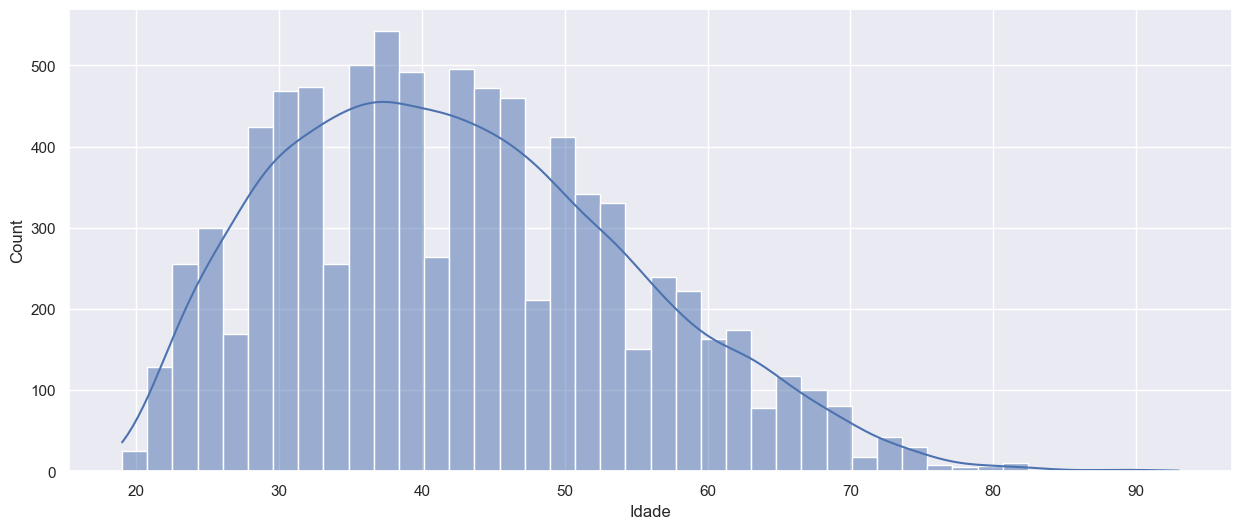

In [ ]:
sns.set()
plt.figure(figsize=(15,6))
sns.histplot(x=havan_idade['Idade'], kde=True)

In [ ]:
havan_idade.groupby(by='medium')['Idade'].mean()

medium
E-MAIL      41.659559
ORGANICO    39.278396
PUSH        41.949192
SMS         42.916315
URA         23.000000
WHATSAPP    42.729675
Name: Idade, dtype: float64

In [ ]:
havan_idade[(havan_idade['operation_value'] > 2000) & havan_idade['operation_value'] < 5001].groupby(by='medium')['Idade'].mean()

medium
E-MAIL      41.659559
ORGANICO    39.278396
PUSH        41.949192
SMS         42.916315
URA         23.000000
WHATSAPP    42.729675
Name: Idade, dtype: float64

In [ ]:
cc_idade = ''' 
with cash as(
select
    p.creditor_id,
    to_char(payed_date::date,'YYYY-MM') payed_date,
    FLOOR(DATEDIFF(day, birthday, CURRENT_DATE) / 365.25) AS idade,
    sum(p.value * pot.fee) comissionado
from  quiteja_lake.payment p
left join (
    select
        deal_id,
        max(days_of_delay) days_of_delay
    from
        quiteja_lake.operation o
    where
        o.active is true
    group by
        1) o on
                o.deal_id = p.deal_id
left join quiteja_lake.potential pot on    o.days_of_delay between coalesce(pot.min_days_of_delay,    0) and coalesce(pot.max_days_of_delay,    999999)
    and pot.active is true
    and pot.creditor_id = p.creditor_id
left join quiteja_lake.deal d on p.deal_id = d.id
left join quiteja_lake.customer on d.customer_id = customer.id 
where
                1 = 1
    and date(p.payed_date) between '2024-01-01'::date and current_date::date 
     and p.status = 'PAYED'
    and p.type = 'DOWN_PAYMENT'
    and p.creditor_id = '37'
group by
    1,2,3),
    
custo as (
select 
	to_char(f.created_at::date, 'YYYY-MM') created_at,
	FLOOR(DATEDIFF(day, birthday, CURRENT_DATE) / 365.25) AS idade,
    sum(approach_cost) custo_geral
from
	quiteja_dados.analitico_estimulos_37 ae 
join quiteja_lake.firing f on f.id = ae.firing_id
join quiteja_lake.customer on customer.id = ae.customer_id
where 
    f.created_at::date  between '2024-01-01'::date and current_date::date 
group by 1,2)


select 
custo.created_at,
cash.idade,
comissionado::float,
custo_geral::float,
producao,
case when custo_geral = 0 then comissionado else comissionado  / custo_geral::float end cash_custo
from cash
join custo on cash.idade = custo.idade and custo.created_at = cash.payed_date
join (
select 
to_char (ap.created_at, 'YYYY-MM') created_at,
FLOOR(DATEDIFF(day, birthday, CURRENT_DATE) / 365.25) AS idade,
count(deal_id) producao
from quiteja_dados.analitico_producao_37 ap
join quiteja_lake.deal on ap.deal_id = deal.id
join quiteja_lake.customer on customer.id = deal.customer_id
group by 1,2
) producao on custo.created_at = producao.created_at and cash.idade = producao.idade
order by 1, 2 
'''

In [ ]:
cc_idade = sql_df(cc_idade)

In [ ]:
cc_idade['idade'] = cc_idade['idade'].astype('int')

In [ ]:
group_idade = cc_idade.groupby(by='idade')['comissionado','custo_geral','producao','cash_custo'].mean().reset_index()
group_idade[group_idade['cash_custo'] > 0.7]

C:\Users\mateus.schualtz\AppData\Local\Temp\ipykernel_14044\1122916376.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  group_idade = cc_idade.groupby(by='idade')['comissionado','custo_geral','producao','cash_custo'].mean().reset_index()


,idade,comissionado,custo_geral,producao,cash_custo
0,20,15.957575,45.167750,4.500000,0.336456
1,21,24.988160,110.989720,9.400000,0.225364
2,22,37.586817,156.968650,13.000000,0.275429
3,23,97.780740,287.077360,20.400000,0.340339
4,24,140.396933,313.050333,24.333333,0.458233
5,25,168.526767,319.512450,24.833333,0.445968
6,26,142.231050,330.300833,25.166667,0.467296
7,27,90.034460,393.090220,31.200000,0.227426
8,28,180.003517,377.342050,34.833333,0.437052
9,29,219.821967,407.815167,35.833333,0.648645


<Axes: xlabel='idade', ylabel='cash_custo'>

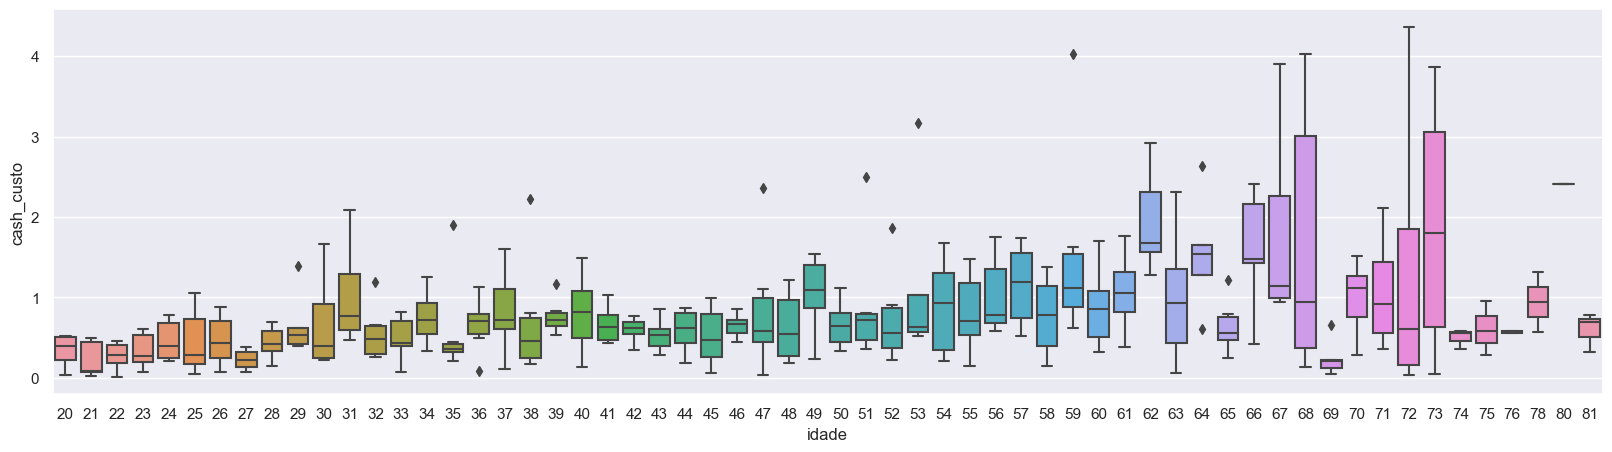

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(data=cc_idade[cc_idade['cash_custo'] < 5], x= 'idade', y='cash_custo')

## Bases P/ Exportar

### Valor Devido

In [ ]:
deals_havan_faixa_vd = ''' 
select 
distinct deal_id
from consolidacao_carteira.deal_37 d
join consolidacao_carteira.customer_37 c on d.customer_id = c.customer_id  and c.is_approachable = true
join consolidacao_carteira.contact_37 ct on c.customer_id = ct.customer_id and ct.is_blacklist = false and ct.is_quarentine = false and ct.is_contact_notifiable = true
where debt_value between 2000 and 5000
and d.has_confirmed_proposal = false
and d.allows_approaches = true
and d.allows_negotiation = true
'''

In [ ]:
deals_havan_faixa_vd = sql_df(deals_havan_faixa_vd)

In [ ]:
deals_havan_faixa_vd['Tag'] = 'Valor_Devido_2000_5000'

In [ ]:
deals_havan_faixa_vd.to_csv('Tag_Faixa_Valor_Devido.csv',index_label=False)

### Idade

In [ ]:
deals_havan_idade = ''' 
select 
distinct deal_id,
cm.birthday
from consolidacao_carteira.deal_37 d
join consolidacao_carteira.customer_37 c on d.customer_id = c.customer_id  and c.is_approachable = true
join consolidacao_carteira.contact_37 ct on c.customer_id = ct.customer_id and ct.is_blacklist = false and ct.is_quarentine = false and ct.is_contact_notifiable = true
join quiteja_lake.customer cm on cm.id = c.customer_id 
where d.has_confirmed_proposal = false
and d.allows_approaches = true
and d.allows_negotiation = true
and birthday is not null

'''

In [ ]:
deals_havan_idade = sql_df(deals_havan_idade)

In [ ]:
deals_havan_idade['birthday'] = pd.to_datetime(deals_havan_idade['birthday'], errors='coerce')
deals_havan_idade['Idade'] = deals_havan_idade['birthday'].apply(lambda x: pd.to_datetime('today').year - x.year - ((pd.to_datetime('today').month, pd.to_datetime('today').day) < (x.month, x.day)))

In [ ]:
deals_havan_idade = deals_havan_idade[(deals_havan_idade['Idade'] > 29) & (deals_havan_idade['Idade'] < 56)]['deal_id'].reset_index()

In [ ]:
deals_havan_idade['tag'] = 'Base_Idade_30_55'

In [ ]:
deals_havan_idade.to_csv('Tag_Havan_Idade.csv',index_label=False)

In [ ]:
cc_canal = ''' 
with cash as(
select
    p.creditor_id,
    payed_date::date,
    case when pm.medium = 'push' then 'PUSH'
    	 when pm.medium = 'whatsapp' then 'WHATSAPP'
    	 when pm.medium = 'sms' then 'SMS'
    	 when pm.medium = 'email' then 'EMAIL'
    	 else 'ORGANIC'
    	 end canal,
    sum(p.value * pot.fee) comissionado
from
                quiteja_lake.payment p
left join (
    select
        deal_id,
        max(days_of_delay) days_of_delay
    from
        quiteja_lake.operation o
    where
        o.active is true
    group by
        1) o on
                o.deal_id = p.deal_id
left join quiteja_lake.potential pot on    o.days_of_delay between coalesce(pot.min_days_of_delay,    0) and coalesce(pot.max_days_of_delay,    999999)
    and pot.active is true
    and pot.creditor_id = p.creditor_id
left join quiteja_lake.proposal pp on pp.deal_id = o.deal_id and pp.status = 'AGREED'
join quiteja_lake.proposal_marketing pm on pp.id = pm.proposal_id
where
                1 = 1
    and date(p.payed_date) between '2024-01-01'::date and current_date::date 
     and p.status = 'PAYED'
    and p.type = 'DOWN_PAYMENT'
    and p.creditor_id = '37'
group by
    1,2,3),
    
custo as (
select 
	created_at::date,
	approach_type,
    creditor_id,
    sum(notifications * approach_cost) custo_geral
from
    quiteja_lake.firing
where 
    created_at::date  between '2024-01-01'::date and current_date::date 
    and creditor_id = 37
group by 1,2,3)


select 
created_at,
approach_type,
comissionado::float,
custo_geral::float,
case when custo_geral = 0 then 0 else comissionado  / custo_geral::float end cash_custo
from cash
join custo on cash.canal = custo.approach_type and custo.created_at = cash.payed_date
where approach_type not in ('ORGANIC', 'PUSH')
order by 1, 2 desc


'''

In [ ]:
cc_canal = sql_df(cc_canal)

In [ ]:
cc_canal['created_at'] = pd.to_datetime(cc_canal['created_at'])
cc_canal['Dia'] = cc_canal['created_at'].dt.day_name()

In [ ]:
modelo_cc = ols('cash_custo ~ Dia * approach_type', data = cc_canal).fit()
resultado_cc = sm.stats.anova_lm(modelo_cc)
resultado_cc

,df,sum_sq,mean_sq,F,PR(>F)
Dia,5.0,3.233104,0.646621,0.447089,0.815150
approach_type,2.0,11.280300,5.640150,3.899738,0.021643
Dia:approach_type,10.0,12.028760,1.202876,0.831698,0.598486
Residual,223.0,322.522564,1.446290,NaN,NaN


In [ ]:
@interact(x=['approach_type','Dia'], y=['comissionado','custo_geral','cash_custo'])
def boxplot(x,y):
    fig, (ax1) = plt.subplots(1, figsize=(30, 9))
    sns.boxplot(x=x, y=y, data=cc_canal[cc_canal['cash_custo'] < 5], ax=ax1)
    plt.xticks(rotation=45);

interactive(children=(Dropdown(description='x', options=('approach_type', 'Dia'), value='approach_type'), Drop…

In [ ]:
base_genero = ''' 
select 
distinct deal_id,
cc.name,
ng.sexo 
from consolidacao_carteira.deal_37 d
join consolidacao_carteira.customer_37 c on d.customer_id = c.customer_id  and c.is_approachable = true
join consolidacao_carteira.contact_37 ct on c.customer_id = ct.customer_id and ct.is_blacklist = false and ct.is_quarentine = false and ct.is_contact_notifiable = true
left join quiteja_lake_restrict.customer cc on d.customer_id = cc.id 
join quiteja_develop.nomes_genero ng on upper(SPLIT_PART(cc."name", ' ', 1)) = upper(ng.nome) 
where d.has_confirmed_proposal = false
and d.allows_approaches = true
and d.allows_negotiation = true
and ct.has_hot is true

''' 

In [ ]:
base_genero = sql_df(base_genero)

In [ ]:
base_feminina = base_genero[base_genero['sexo'] == 'F']
base_feminina['Tag'] = 'Base_Feminina_Hot'

C:\Users\mateus.schualtz\AppData\Local\Temp\ipykernel_13844\4263762466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_feminina['Tag'] = 'Base_Feminina_Hot'


In [ ]:
base_masculina = base_genero[base_genero['sexo'] == 'M']
base_masculina['Tag'] = 'Base_Masculina_Hot'

C:\Users\mateus.schualtz\AppData\Local\Temp\ipykernel_13844\3139310356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_masculina['Tag'] = 'Base_Masculina_Hot'


In [ ]:
base_feminina.to_csv('base_feminina.csv')
base_masculina.to_csv('base_masculina.csv')